In [1]:
import os
import cv2
import random
import math
import PIL.Image as Image
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model 
import scipy.ndimage as ndi
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Iris Biometric Identification

## Vasil Kichukov

## Abstract


__What is Iris Biometric Identification?__

Iris biometric identification uses the unique patterns in the colored part of the eye (the iris) to identify individuals. Even the left and right irises of a person are unique. This method is highly secure and reliable, as no two people have the same iris patterns, making it one of the most accurate forms of biometric identification.

__Why is This Project Important?__

This project is important because iris recognition provides one of the most accurate ways to identify people. By developing a system that can segment the iris from the surrounding eye region, we can make the recognition process more precise and faster, which is crucial for secure applications.

__How Can This Be Used in Business?__

Iris recognition can be used in various industries for secure access, identity verification, and fraud prevention. It can improve security for businesses, banking, healthcare, and even in mobile devices, allowing for seamless and secure user experiences.

__What is the Purpose of This Project?__

The purpose of this project is to create a reliable system for accurately segmenting the iris from the eye using deep learning techniques. After segmentation, the project also focuses on recognizing the individual by comparing their segmented iris patterns to a database, allowing for secure identification and authentication. This process is essential for ensuring that the model can not only isolate the iris but also verify the identity of the person, which is crucial for applications like access control and secure transactions.

## Table of Contents

TODO

## Introduction

Iris biometric identification offers one of the most secure and accurate methods of recognizing individuals, as each person’s iris patterns are unique. Unlike other biometric traits, the iris remains stable throughout life and is extremely difficult to replicate, making it ideal for high-security applications such as banking, government, and healthcare.


Iris recognition systems are increasingly integrated into various sectors, from border control to mobile devices. These systems are growing in use due to their high accuracy and reliability. However, challenges like accurate segmentation of the iris, varying lighting conditions, and different eye shapes remain, which complicate large-scale deployment. With advancements in AI and machine learning, iris recognition technology is expected to improve in both speed and accuracy. As security needs continue to rise, iris biometric systems will likely play a critical role in personal identification and secure access in the future.

## Dataset Representation

The datasets used in this project are __IITD__ and __CASIA 1000__, which provide a rich collection of iris images for biometric identification tasks.

The __IITD dataset__ (Indian Eye Iris Dataset) was developed by the Indian Institute of Technology Delhi (IITD). It contains a total of __2240 RGB iris images__ collected from 224 individuals, with 10 images per subject. Each image in the dataset is of the size 320x240 pixels, maintaining an __aspect ratio of 4:3__. The corresponding masks for this dataset, which are used for iris segmentation, were obtained from a GitHub repository, and I would like to express my gratitude to the creators of IITD for providing the images and permission to use them for my research purposes. The images are initially in RGB format, but for this project, I converted them to grayscale to simplify processing.

The __CASIA 1000__ dataset was downloaded from Kaggle and is another significant resource for iris recognition. It contains __20,000 grayscale iris images__ from 1000 subjects, with each subject contributing 20 images — 10 images from their left eye and 10 from their right eye. The images in this dataset have a resolution of 640x480 pixels, with an __aspect ratio of 4:3__. The CASIA 1000 dataset offers a diverse set of iris images that will be invaluable for testing and validating the segmentation and recognition models.

While the images in IITD are of smaller resolution, CASIA 1000 offers a larger and more varied collection, ensuring robust model training and evaluation. The IITD dataset is primarily used in this project to create segmentation masks for the main CASIA dataset, enabling effective segmentation of the irises from the CASIA images. These segmentation masks will be crucial in training the models for iris recognition, ensuring high accuracy and reliability in real-world applications. Both datasets play a critical role in this project, enabling the development and testing of advanced segmentation and recognition algorithms for biometric iris identification.

# IITD dataset

In [2]:
BASE_IMAGE_DIR = "data_masks/IITD_dataset"
BASE_MASK_DIR  = "data_masks/IITD_masks"
SAVE_DIR = "./data"
HEIGHT = 240
WIDTH = 320
CHANNELS = 1
ASPECT_RATIO = WIDTH/HEIGHT
SIZE = (WIDTH, HEIGHT)
SIZE_CHANNELS = (WIDTH, HEIGHT, CHANNELS)
BATCH_SIZE = 8
EPOCHS = 24

To reduce hardcoding, we'll keep everything in different variables so we can manipulate it more easily if needed.

### Reading and visualizations

In [3]:
def check_image_dimensions_dir(directory, expected_size, expected_channels):
    incorrect_dimensions = []
    
    if expected_channels == 1:
        expected_mode = 'L'
    elif expected_channels == 3:
        expected_mode = 'RGB'
    else:
        expected_mode = None
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.bmp', '.tiff',)):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        actual_size = img.size
                        actual_mode = img.mode
                        if actual_size != expected_size or (expected_mode and actual_mode != expected_mode):
                            incorrect_dimensions.append((image_path, actual_size, actual_mode))
                except Exception as e:
                    incorrect_dimensions.append((image_path, "Error", str(e)))
                    
    if incorrect_dimensions:
        print(f"{len(incorrect_dimensions)} images with incorrect dimensions {directory}.")
        for i, (file_path, size, mode) in enumerate(incorrect_dimensions[:4]):
            print(f"{file_path} -> size: {size}, mode: {mode}")
    else:
        print(f"All images in {directory} have correct dimensions and mode.")

print("Checking BASE_IMAGE_DIR:")
check_image_dimensions_dir(BASE_IMAGE_DIR, expected_size=SIZE, expected_channels=CHANNELS)
print("\nChecking BASE_MASK_DIR:")
check_image_dimensions_dir(BASE_MASK_DIR, expected_size=SIZE, expected_channels=CHANNELS)

Checking BASE_IMAGE_DIR:
2240 images with incorrect dimensions data_masks/IITD_dataset.
data_masks/IITD_dataset\001\01.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\02.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\03.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\04.bmp -> size: (320, 240), mode: RGB

Checking BASE_MASK_DIR:
All images in data_masks/IITD_masks have correct dimensions and mode.


The function checks whether all the images in a specified folder and its subfolders match the expected size and color channels. It loops through all images in the directory, opens them, and compares their size and mode (grayscale or RGB) with the expected values. If any images have incorrect dimensions or modes, they are listed, and the function prints the first 4 such images along with their size and mode details. If all images are correct, it simply prints a message confirming that everything is fine.

In [4]:
def map_images_to_masks(BASE_IMAGE_DIR, BASE_MASK_DIR):
    image_to_mask_map = {}

    for folder_id in range(1, 225):
        folder_str = f"{folder_id:03d}"
        image_folder_path = os.path.join(BASE_IMAGE_DIR, folder_str)
        
        for i in range(1, 11):
            image_index_str = f"{i:02d}"
            image_filename = f"{image_index_str}.bmp"
            full_image_path = os.path.join(image_folder_path, image_filename)
            mask_filename = f"{folder_str}_{image_index_str}.tiff"
            full_mask_path = os.path.join(BASE_MASK_DIR, mask_filename)
            
            if os.path.exists(full_image_path) and os.path.exists(full_mask_path):
                image_to_mask_map[full_image_path] = full_mask_path
            else:
                print(f"Missing file(s): {full_image_path} or {full_mask_path}")
    
    return image_to_mask_map

image_to_mask_map = map_images_to_masks(BASE_IMAGE_DIR, BASE_MASK_DIR)


print("\nFirst 5 (image -> mask) pairs:")
for idx, (img_path, mask_path) in enumerate(image_to_mask_map.items()):
    print(f"{idx+1}. {img_path} -> {mask_path}")
    if idx == 4:
        break


First 5 (image -> mask) pairs:
1. data_masks/IITD_dataset\001\01.bmp -> data_masks/IITD_masks\001_01.tiff
2. data_masks/IITD_dataset\001\02.bmp -> data_masks/IITD_masks\001_02.tiff
3. data_masks/IITD_dataset\001\03.bmp -> data_masks/IITD_masks\001_03.tiff
4. data_masks/IITD_dataset\001\04.bmp -> data_masks/IITD_masks\001_04.tiff
5. data_masks/IITD_dataset\001\05.bmp -> data_masks/IITD_masks\001_05.tiff


We create a dictionary that links image file paths to their corresponding mask file paths. It loops through the image and mask directories, checks if the files exist, and maps each image to its mask. The function returns the dictionary containing all valid image-mask pairs.

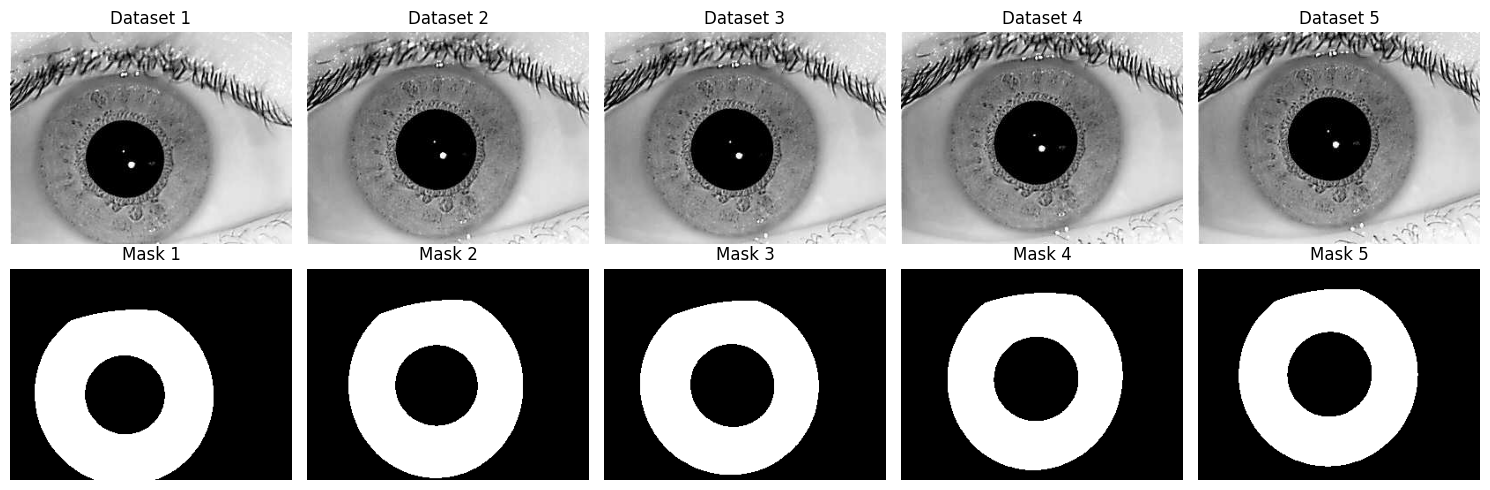

In [5]:
def visualize_images_from_dict(image_to_mask_map, num_images=5):
    selected_pairs = list(image_to_mask_map.items())[:num_images]
    plt.figure(figsize=(15, 5))  
    
    for i, (img_path, mask_path) in enumerate(selected_pairs):
        img = Image.open(img_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Dataset {i+1}")
        plt.axis('off')
        
        mask_img = Image.open(mask_path)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(mask_img, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_from_dict(image_to_mask_map, num_images=5)

## Iris Segmentation

In [6]:
def split_dataset(image_to_mask_map, train_ratio=0.8):
    pairs = list(image_to_mask_map.items())
    random.shuffle(pairs)
    split_idx = int(train_ratio * len(pairs))
    
    train_pairs = pairs[:split_idx]
    val_pairs   = pairs[split_idx:]
    
    return train_pairs, val_pairs

train_pairs, val_pairs = split_dataset(image_to_mask_map, train_ratio=0.8)

print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")

Train pairs: 1792
Validation pairs: 448


We split the dataset of image-mask pairs into training and validation sets based on the specified train_ratio. It first shuffles the image-mask pairs to ensure a random split, then divides the shuffled pairs into two sets: one for training and the other for validation. The training set contains train_ratio (default 80%) of the total pairs, and the remaining pairs are allocated to the validation set. The function returns the two sets: train_pairs and val_pairs

In [7]:
def load_image_mask(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    img_norm = img.astype(np.float32) / 255.0
    msk_bin = (msk > 127).astype(np.float32)
    
    img_norm = np.expand_dims(img_norm, axis=-1)
    msk_bin  = np.expand_dims(msk_bin, axis=-1)
    
    return img_norm, msk_bin

The function loads an image and its corresponding mask from the specified file paths. Although the image files are originally in RGB format, the function reads them as grayscale using OpenCV. The image is then normalized to the range [0, 1] by dividing its pixel values by 255, and the mask is binarized by setting pixels above a threshold of 127 to 1 (foreground) and below to 0 (background). After processing, both the image and the mask are expanded to have an extra dimension (making them 3D arrays, i.e., (height, width, 1)) to match the input shape required by the model. The function then returns the transformed grayscale image and its corresponding mask.

In [8]:
def augment_image_mask(img, msk):
    if random.random() < 0.5:
        img = tf.image.flip_left_right(img)
        msk = tf.image.flip_left_right(msk)

    if random.random() < 0.5:
        img = tf.image.flip_up_down(img)
        msk = tf.image.flip_up_down(msk)
    
    if random.random() < 0.5:
        img = tf.image.random_brightness(img, max_delta=0.2)
    
    if random.random() < 0.5:
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.05)
        img = img + noise
        img = tf.clip_by_value(img, 0.0, 1.0)
    
    if random.random() < 0.5:
        img_np = img.numpy()
        img_np = np.squeeze(img_np, axis=-1)
        ksize = random.choice([3, 5])
        img_np = cv2.GaussianBlur(img_np, (ksize, ksize), 0)
        img_np = np.expand_dims(img_np, axis=-1)
        img = tf.convert_to_tensor(img_np, dtype=tf.float32)
    
    return img, msk

In [9]:
def data_generator(pairs_list, batch_size=8, augment=False):
    while True:
        random.shuffle(pairs_list)
        for i in range(0, len(pairs_list), batch_size):
            batch_pairs = pairs_list[i:i+batch_size]
            images = []
            masks = []
            
            for (img_path, msk_path) in batch_pairs:
                img_arr, msk_arr = load_image_mask(img_path, msk_path)
                img_tensor = tf.convert_to_tensor(img_arr, dtype=tf.float32)
                msk_tensor = tf.convert_to_tensor(msk_arr, dtype=tf.float32)
                
                if augment:
                    img_tensor, msk_tensor = augment_image_mask(img_tensor, msk_tensor)
                
                images.append(img_tensor.numpy())
                masks.append(msk_tensor.numpy())
            
            images = np.array(images, dtype=np.float32)
            masks  = np.array(masks,  dtype=np.float32)
            
            yield images, masks

Generator yields batches of image-mask pairs for training a model. It continuously loops through the provided list of image-mask pairs (pairs_list), shuffles them, and splits them into batches of a specified size (batch_size). For each batch, it loads the corresponding images and masks using the load_image_mask function, processes them into grayscale format, normalizes the images, and binarizes the masks. The images and masks are then converted to NumPy arrays with a shape of (batch_size, height, width, 1) to match the model's input requirements. The function yields these batches of processed images and masks indefinitely for training.

## U-net - custom model

In [10]:
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

The Dice coefficient is used for segmentation because it effectively measures the overlap between the predicted mask and the ground truth mask. Unlike accuracy, which can be misleading in cases of imbalanced datasets, the Dice coefficient focuses on how well the model captures the iris area by comparing the true positive pixels in both the predicted and actual masks.

In [4]:
def get_early_stopping_callback():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2, 
        restore_best_weights=True
    )

EarlyStopping callback monitors the validation loss during training. If the validation loss doesn't improve for 2 consecutive epochs (patience=2), training stops early and the best model weights are restored.

In [12]:
def create_unet(input_shape=(240,320,1), dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    d1 = layers.Dropout(dropout_rate)(c1)
    p1 = layers.MaxPooling2D((2,2))(d1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    d2 = layers.Dropout(dropout_rate)(c2)
    p2 = layers.MaxPooling2D((2,2))(d2)

    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    d3 = layers.Dropout(dropout_rate)(c3)

    u4 = layers.UpSampling2D((2,2))(d3)
    concat4 = layers.concatenate([u4, c2], axis=-1)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(concat4)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2,2))(c4)
    concat5 = layers.concatenate([u5, c1], axis=-1)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(concat5)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

The __U-Net architecture__ is a popular model for image segmentation tasks. It consists of two main parts: downsampling (contracting path) and upsampling (expansive path).

__Downsampling__ (Contracting Path): This part extracts features from the input image using convolutional layers with ReLU activation and max-pooling layers for downsampling. It captures spatial hierarchies of the image.

The first convolution block (c1) has two convolutional layers with 32 filters, followed by a max-pooling operation.
The second block (c2) uses 64 filters and also follows the same pattern.
The third block (c3) has 128 filters and serves as the bottleneck of the network, where the most abstract features are captured.

__Upsampling__ (Expansive Path): This part rebuilds the segmented output using up-sampling layers followed by convolutions. It combines the features from earlier layers using skip connections (concatenation) to preserve high-resolution details. U4 and u5 are upsampling layers, each followed by convolution blocks (c4, c5) to refine the segmentation.

Output Layer: The final layer produces a single channel output (grayscale), using a sigmoid activation for pixel-wise classification (foreground or background). The sigmoid activation ensures that the model outputs a probability map, where values closer to 1 represent foreground (iris) and values closer to 0 represent the background.

In [13]:
train_gen = data_generator(train_pairs, batch_size=BATCH_SIZE, augment=True)
val_gen   = data_generator(val_pairs, batch_size=BATCH_SIZE, augment=False)

model_unet = create_unet(input_shape=(240, 320, 1), dropout_rate=0.2)
model_unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_metric])

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 320, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 240, 320, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 240, 320, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 240, 320, 32)         0         ['conv2d_1[0][0]']            
                                                                                              

The model is compiled using the Adam optimizer, which adapts the learning rate based on training, and the binary cross-entropy loss function, suitable for binary segmentation tasks (iris vs. background).

In [14]:
steps_per_epoch  = len(train_pairs) // BATCH_SIZE
validation_steps = len(val_pairs)   // BATCH_SIZE

history_unet = model_unet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=len(train_pairs) // BATCH_SIZE,
    validation_steps=len(val_pairs) // BATCH_SIZE,
    callbacks=[get_early_stopping_callback()]
)

Epoch 1/24
  8/224 [>.............................] - ETA: 9:10 - loss: 0.5211 - dice_metric: 0.4131 

KeyboardInterrupt: 

The training shows steady progress in both loss reduction and improvement in segmentation quality. The model is learning effectively on the training set while maintaining a good generalization to the validation set. 

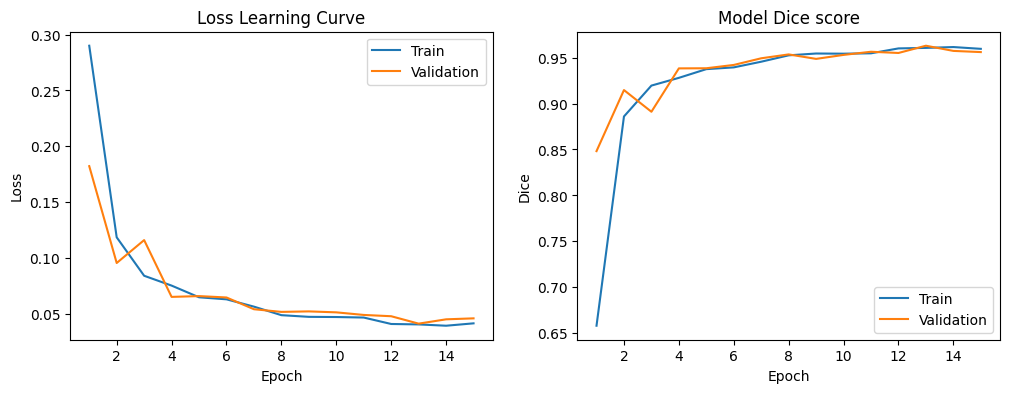

In [180]:
def plot_learning_curves(history_unet):
    train_loss = history_unet.history_unet['loss']
    val_loss   = history_unet.history_unet['val_loss']
    
    train_dice = history_unet.history_unet['dice_metric']
    val_dice   = history_unet.history_unet['val_dice_metric']
    
    epochs_range = range(1, len(train_loss)+1)
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train')
    plt.plot(epochs_range, val_loss, label='Validation')
    plt.title('Loss Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_dice, label='Train')
    plt.plot(epochs_range, val_dice, label='Validation')
    plt.title('Model Dice score')
    plt.ylabel('Dice')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()

plot_learning_curves(history_unet)

__Overfitting__: There isn't a clear sign of overfitting, as the training and validation curves are fairly close. However, some fluctuations in the validation loss and Dice score suggest that the model might slightly overfit towards the end of training. The validation dice is close to training dice, which means the model is generalizing well to unseen data. The slight fluctuation (val_dice_metric dropped) suggests a bit of noise.

__Convergence__: Both the loss and Dice metrics are leveling out after around 10 epochs, which indicates that the model has likely reached its optimal performance on the given data. Further epochs will not result in improvements.

__Model Performance__: The model's ability to segment the iris seems to be strong, with a validation Dice score approaching 0.95 and a validation loss that's quite low, suggesting good segmentation performance on unseen data.

In [181]:
def create_overlay(original_path, pred_mask, alpha=0.4):
    pred_mask = pred_mask.squeeze(axis=-1)

    orig = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    orig_color = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
    
    green_mask = np.zeros_like(orig_color)
    green_mask[...,1] = (pred_mask * 255).astype(np.uint8)

    overlay = cv2.addWeighted(orig_color, 1.0, green_mask, alpha, 0)
    return overlay

We create an image overlay where the predicted mask is displayed on top of the original image. It first reads the original image and converts it to a color format. Then, it creates a green mask from the predicted mask and overlays it on the original image with a specified transparency (alpha). The resulting image shows the original iris image with the predicted mask highlighted in green.

Found 1 poorly segmented images (dice < 0.7):
data_masks/IITD_dataset\003\01.bmp => dice=0.358


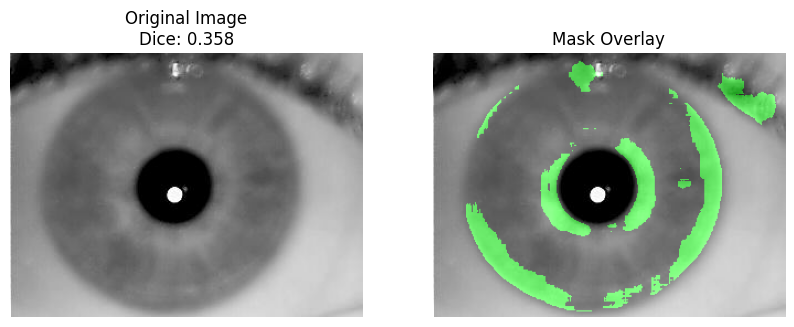

In [183]:
def evaluate_segmentation_per_image(pairs_list, model, threshold=0.5, dice_threshold=0.7):
    poorly_segmented = []
    
    for (img_path, msk_path) in pairs_list:
        img_arr, msk_arr = load_image_mask(img_path, msk_path)

        pred = model.predict(np.expand_dims(img_arr, axis=0), verbose=0)
        pred_2d = pred[0, ..., 0]  
        pred_bin = (pred_2d > threshold).astype(np.float32)

        y_true_f = msk_arr.flatten()
        y_pred_f = pred_bin.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        dice = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-6)

        if dice < dice_threshold:
            poorly_segmented.append((img_path, dice, pred_bin))

    if poorly_segmented:
        print(f"Found {len(poorly_segmented)} poorly segmented images (dice < {dice_threshold}):")

        for img_path, dice_val, pred_mask in poorly_segmented:
            print(f"{img_path} => dice={dice_val:.3f}")

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            pred_mask_for_overlay = cv2.resize(
                pred_mask, 
                (img.shape[1], img.shape[0]),  # (width, height) in OpenCV
                interpolation=cv2.INTER_NEAREST
            )

            green_mask = np.zeros_like(img_color)
            green_mask[..., 1] = (pred_mask_for_overlay * 255).astype(np.uint8)

            overlay = cv2.addWeighted(img_color, 1.0, green_mask, 0.5, 0)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img_color, cmap='gray')
            plt.title(f"Original Image\nDice: {dice_val:.3f}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(overlay)
            plt.title("Mask Overlay")
            plt.axis('off')

            plt.show()
    else:
        print("All images have a higher score than the dice threshold.")


poorly_segmented_images = evaluate_segmentation_per_image(val_pairs, model, threshold=0.5, dice_threshold=0.70)

The function checks each image's Dice score. If the score is below the specified threshold (default 0.7), the image is considered poorly segmented. The function prints the image path, Dice score, and displays an overlay of the predicted mask on the original image for inspection. Only one image had a low Dice score of 0.358, and it will display the overlay for review.

In [248]:
os.makedirs(SAVE_DIR, exist_ok=True)
model_path = os.path.join(SAVE_DIR, "seg_model.h5")
model_unet.save(model_path)
print(f"The segmentation model has been successfully saved as 'seg_model.h5' in the folder '{SAVE_DIR}'.")

The segmentation model has been successfully saved as 'seg_model.h5' in the folder './data'.


C:\Users\Gaming PC\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### U-net - Implementation from a Paper

In [15]:
IMG_HEIGHT = 576
IMG_WIDTH = 576
BATCH_SIZE = 4
EPOCHS_SIZE = 24

In [16]:
def load_image_mask_paper(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    msk_resized = cv2.resize(msk, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

    img_norm = img_resized.astype(np.float32) / 255.0
    msk_bin  = (msk_resized > 127).astype(np.float32)

    img_norm = np.expand_dims(img_norm, axis=-1)
    msk_bin  = np.expand_dims(msk_bin,  axis=-1)

    return img_norm, msk_bin

In [17]:
def augment_image_and_mask(img, msk):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    msk_tensor = tf.convert_to_tensor(msk, dtype=tf.float32)
    
    if random.random() < 0.5:
        img_tensor = tf.image.flip_left_right(img_tensor)
        msk_tensor = tf.image.flip_left_right(msk_tensor)
    
    if random.random() < 0.5:
        img_tensor = tf.image.flip_up_down(img_tensor)
        msk_tensor = tf.image.flip_up_down(msk_tensor)
    
    if random.random() < 0.5:
        img_tensor = tf.image.random_brightness(img_tensor, max_delta=0.2)
    
    if random.random() < 0.5:
        noise = tf.random.normal(shape=tf.shape(img_tensor), mean=0.0, stddev=0.05)
        img_tensor = img_tensor + noise
        img_tensor = tf.clip_by_value(img_tensor, 0.0, 1.0)
    
    if random.random() < 0.5:
        img_np = img_tensor.numpy()
        img_np = np.squeeze(img_np, axis=-1)
        ksize = random.choice([3, 5])
        img_np = cv2.GaussianBlur(img_np, (ksize, ksize), 0)
        img_np = np.expand_dims(img_np, axis=-1)
        img_tensor = tf.convert_to_tensor(img_np, dtype=tf.float32)
    
    return img_tensor.numpy(), msk_tensor.numpy()

In [18]:
def data_generator_paper(pairs_list, batch_size=BATCH_SIZE, augment=True):
    while True:
        random.shuffle(pairs_list)
        for i in range(0, len(pairs_list), batch_size):
            batch_pairs = pairs_list[i : i+batch_size]
            images = []
            masks  = []
            for (img_path, msk_path) in batch_pairs:
                img_arr, msk_arr = load_image_mask_paper(img_path, msk_path)
                
                if augment:
                    img_arr, msk_arr = augment_image_and_mask(img_arr, msk_arr)
                
                images.append(img_arr)
                masks.append(msk_arr)
            images = np.array(images, dtype=np.float32)
            masks  = np.array(masks, dtype=np.float32)
            yield images, masks

In [19]:
class CropToMatch(layers.Layer):
    def call(self, inputs):
        source, target = inputs
        s = tf.shape(source)
        t = tf.shape(target)

        height_diff = s[1] - t[1]
        width_diff  = s[2] - t[2]

        crop_top  = height_diff // 2
        crop_left = width_diff  // 2

        return tf.slice(
            source,
            [0, crop_top, crop_left, 0],
            [-1, s[1] - crop_top*2, s[2] - crop_left*2, -1]
        )

In [20]:
def unet_paper(
    input_shape=(576, 576, 1),
    num_classes=1,
    initial_filters=64,
    final_activation='sigmoid'
):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    c5 = layers.Conv2D(initial_filters*16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = layers.Conv2D(initial_filters*16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    u6 = layers.Conv2DTranspose(initial_filters*8, (2,2), strides=2, kernel_initializer='he_normal')(c5)
    merge6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    c6 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    u7 = layers.Conv2DTranspose(initial_filters*4, (2,2), strides=2, kernel_initializer='he_normal')(c6)
    merge7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    c7 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    u8 = layers.Conv2DTranspose(initial_filters*2, (2,2), strides=2, kernel_initializer='he_normal')(c7)
    merge8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    c8 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    u9 = layers.Conv2DTranspose(initial_filters, (2,2), strides=2, kernel_initializer='he_normal')(c8)
    merge9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    c9 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    outputs = layers.Conv2D(num_classes, (1,1), activation=final_activation)(c9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [21]:
def train_unet_paper(
    train_pairs, val_pairs,
    steps_per_epoch, validation_steps,
    epochs=EPOCHS_SIZE,
    optimizer_params=None,
    num_classes=1,
    final_activation='sigmoid',
    loss='binary_crossentropy',
    metrics=None,
    plot_model_diagram=False
):
    if metrics is None:
        metrics = [dice_metric]

    model = unet_paper(
        input_shape=(576, 576, 1),
        num_classes=num_classes,
        final_activation=final_activation
    )
    
    print("---- Model Summary ----")
    model.summary()

    if plot_model_diagram:
        tf.keras.utils.plot_model(
            model,
            to_file='unet_architecture.png',
            show_shapes=True,
            show_layer_names=True
        )
        print("Model diagram saved as 'unet_architecture.png'")

    if optimizer_params is None:
        optimizer_params = {'learning_rate':1e-4}  
    optimizer = tf.keras.optimizers.Adam(**optimizer_params)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    train_gen = data_generator_paper(train_pairs, batch_size=BATCH_SIZE, augment=True)
    val_gen   = data_generator_paper(val_pairs,   batch_size=BATCH_SIZE, augment=False)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[get_early_stopping_callback()]
    )

    return model, history

In [22]:
STEPS_PER_EPOCH  = len(train_pairs) // BATCH_SIZE
VALIDATION_STEPS = len(val_pairs)   // BATCH_SIZE

model_paper, history_paper = train_unet_paper(
    train_pairs, val_pairs,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS_SIZE,
    optimizer_params={'learning_rate':1e-4},
    num_classes=1,
    final_activation='sigmoid',
    loss='binary_crossentropy',
    metrics=[dice_metric],
    plot_model_diagram=False
)

---- Model Summary ----
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 576, 576, 1)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 576, 576, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 576, 576, 64)         36928     ['conv2d_11[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 288, 288, 64)         0         ['conv2d_12[0][0]']           
 g2D)                                                               

KeyboardInterrupt: 

In [ ]:
plot_learning_curves(history_paper)

In [ ]:
poorly_segmented_images = evaluate_segmentation_per_image(
    val_pairs, model_paper, threshold=0.5, dice_threshold=0.70
)

In [249]:
os.makedirs(SAVE_DIR, exist_ok=True)
model_paper_path = os.path.join(SAVE_DIR, "seg_model_paper.h5")
model_paper.save(model_paper_path)
print(f"The second segmentation model has been saved as 'seg_model_paper.h5' in the folder '{SAVE_DIR}'.")

The second segmentation model has been saved as 'seg_model_same.h5' in the folder './data'.


While the models perform well on the IITD dataset, they struggle to generalize to the CASIA 1000 dataset, likely due to overfitting and the differences in image quality, lighting, and reflections. Unfortunately, due to time constraints, further development to address these issues will be reserved for future work. However, the proposed improvements, adding noise, regularization(dropout), and training on a more diverse dataset, are promising directions for enhancing the model's robustness and generalization capabilities.

# CASIA dataset

In [159]:
CSV_FILE = "./data/iris_thousands.csv"
PUPIL_DATASET_DIR = ".//data/pupil_dataset"
PUPIL_PRED_DATASET_DIR = ".//data/pupil_dataset_pred"
WORK_DATASET_DIR = ".//data/work_dataset"
MASK_DATASET_DIR = "./data/mask_dataset/"
SEG_MODEL = "./data/seg_model.h5"
ORIGINAL_CASIA_DIR = "./data/CASIA-Iris-Thousand/"
NUM_CLASSES = 2000
IMAGE_WIDTH = 640    
IMAGE_HEIGHT = 480
IMAGE_CHANNELS = 1
TARGET_SIZE = (320, 240)
TARGET_SIZE_2 = (576, 576)
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SIZE_CHANNELS = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 24

### Reading and visualizations

In [5]:
iris_data = pd.read_csv(CSV_FILE)
check_image_dimensions_dir(ORIGINAL_CASIA_DIR, expected_size=IMAGE_SIZE, expected_channels=IMAGE_CHANNELS)

All images in ./data/CASIA-Iris-Thousand/ have correct dimensions and mode.


In [6]:
def check_class_distribution(dataset):
    class_counts = dataset['Label'].value_counts()
    if class_counts.min() != class_counts.max():
        print("Class distribution is imbalanced.")
    else:
        print("Class distribution is balanced.")

check_class_distribution(iris_data)

Class distribution is balanced.


In [7]:
def update_paths(iris_df, base_dir, target_column):
    corrected_paths = []
    missing_files = []

    for index, row in iris_df.iterrows():
        label = row['Label']
        image_filename = os.path.basename(row['ImagePath'])
        subject_id, eye = label.split("-")

        corrected_path = os.path.join(base_dir, subject_id, eye, image_filename)

        if not os.path.exists(corrected_path):
            alternative_ext = ".bmp" if image_filename.lower().endswith(".jpg") else ".jpg"
            corrected_path_alt = os.path.splitext(corrected_path)[0] + alternative_ext

            if os.path.exists(corrected_path_alt):
                corrected_path = corrected_path_alt
            else:
                missing_files.append(corrected_path)

        corrected_paths.append(corrected_path)

    iris_df[target_column] = corrected_paths

    if not missing_files:
        print("✅ All image paths are valid and exist in the dataset directory.")
    else:
        print(f"⚠️ {len(missing_files)} missing image(s) found:")
        for file in missing_files[:5]:
            print(file)

    return iris_df 

In [9]:
iris_data = update_paths(iris_data, ORIGINAL_CASIA_DIR, "OriginalPath")
iris_data = iris_data.drop(columns=["Unnamed: 0", "ImagePath"])
iris_data.head(4)

✅ All image paths are valid and exist in the dataset directory.


Unnamed: 0  Label                                          ImagePath  \
0           0  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
1           1  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
2           2  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
3           3  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   

                                    OriginalPath  
0  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg  
1  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg  
2  ./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg  
3  ./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg

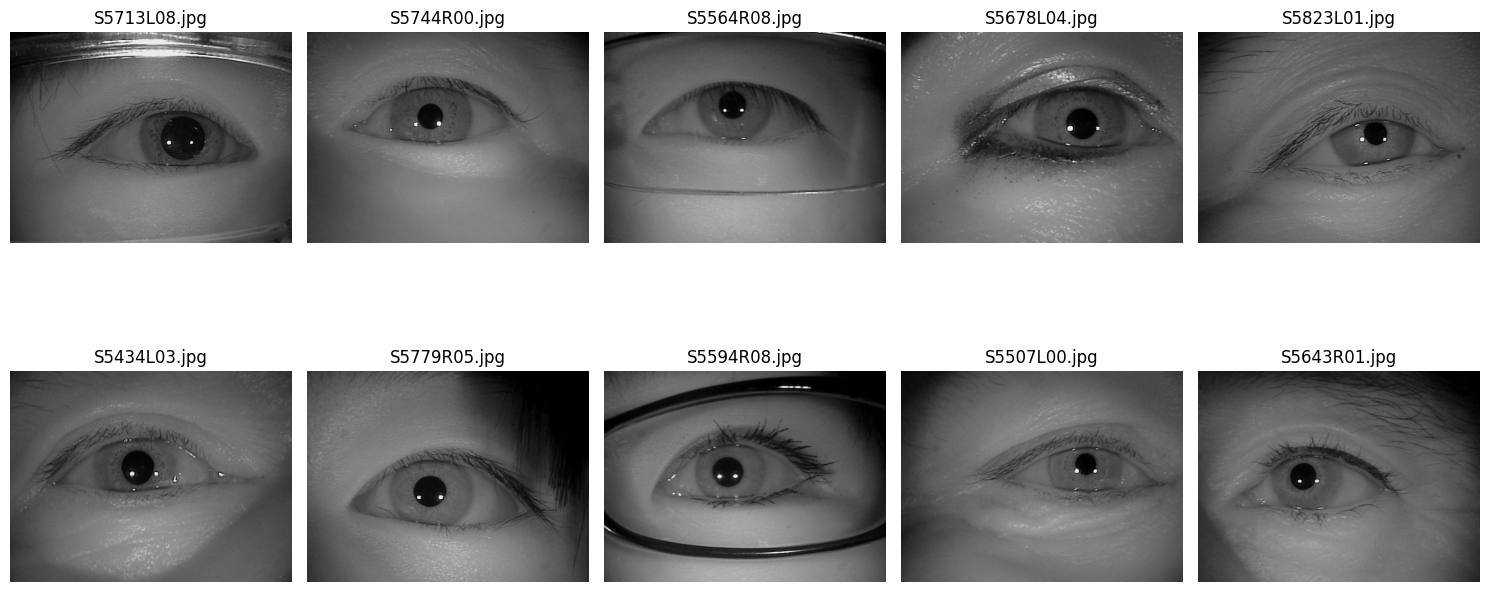

In [10]:
def visualize_images(dataset, column_name, num_images):
    sample_images = dataset.sample(num_images)[column_name].tolist()
    plt.figure(figsize=(15, 8))
    
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        if IMAGE_CHANNELS == 1:
            img = img.convert("L")
        
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img, cmap="gray" if IMAGE_CHANNELS == 1 else None)
        plt.title(os.path.basename(image_path))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_images(iris_data, "OriginalPath", num_images=10)

## Pupil Detection (Iris Inner Boundary)

In [28]:
def refine_circle_by_intensity(image, circle, intensity_range, step=2):
    x, y, r = circle
    h, w = image.shape
    refined_r = r

    for i in range(-step, step + 1):
        temp_r = r + i
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (x, y), temp_r, 1, thickness=1)
        band_pixels = image[mask == 1]

        if np.mean(band_pixels) >= intensity_range[0] and np.mean(band_pixels) <= intensity_range[1]:
            refined_r = temp_r
    return (x, y, refined_r)

Adjusts the radius of a detected pupil circle by checking the pixel intensity within the circle. It tests different radii within a specified range and selects the one where the average intensity falls within the given range. The function returns the refined circle with the best fitting radius.

In [29]:
def detect_pupil(image, param1=80, param2=30, min_radius=20, max_radius=80):
    gray = cv2.GaussianBlur(image, (7, 7), 0)
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=param1, param2=param2, 
        minRadius=min_radius, maxRadius=max_radius
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0, 0]
        refined_circle = refine_circle_by_intensity(gray, (x, y, r), intensity_range=(0, 70))
        return refined_circle
    return None

Detecting the pupil in an image using the Hough Circle Transform. It applies a Gaussian blur to the image and then uses cv2.HoughCircles to detect circles that may correspond to the pupil. If a circle is detected, the function refines the radius of the circle based on the pixel intensity inside the circle using the refine_circle_by_intensity function. The function returns the refined circle (x, y, r) if a pupil is detected, or None if no pupil is found.

In [30]:
def save_pupil_for_review(image, pupil_x, pupil_y, pupil_r, img_path):
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    cv2.circle(output_image, (pupil_x, pupil_y), pupil_r, (0, 255, 0), 2)
    cv2.circle(output_image, (pupil_x, pupil_y), 2, (0, 0, 255), 3)

    save_path = os.path.join(PUPIL_DATASET_DIR, os.path.basename(img_path))
    cv2.imwrite(save_path, output_image)

We save an image with the detected pupil highlighted. It first converts the grayscale image to color, then draws a green circle around the detected pupil and a red dot at the center. The image is saved in the pupil_dataset directory with the same name as the original image. This function is useful for reviewing and validating the accuracy of pupil detection results.

In [31]:
def detect_and_store_pupils(image_paths):
    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        pupil = detect_pupil(image)
        if pupil is not None:
            pupil_x, pupil_y, pupil_r = pupil
            save_pupil_for_review(image, pupil_x, pupil_y, pupil_r, img_path)

    print(f"Pupil images saved in: {PUPIL_DATASET_DIR}")
    
os.makedirs(PUPIL_DATASET_DIR, exist_ok=True)
casia_jpg_paths = iris_data["OriginalPath"].tolist()
detect_and_store_pupils(casia_jpg_paths)

✅ Pupil images saved in: .//data/pupil_dataset


All detected pupils are stored in the pupil_dataset folder and prepared for manual review. The algorithm detected 19,241(from 20,000) after manual inspection another 288 were deleted so in total our correctly segmented pupils are __18,953 or 94.75% of all images__.

In [33]:
def process_pupils():
    iris_data["PupilPath"] = ""  
    iris_data["pupil_x"] = None  
    iris_data["pupil_y"] = None  
    iris_data["pupil_radius"] = None 
    iris_data["pupil_detected"] = 0  

    for index, row in iris_data.iterrows():
        img_filename = os.path.basename(row["OriginalPath"])
        img_path = os.path.join(PUPIL_DATASET_DIR, img_filename)

        if os.path.exists(img_path): 
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            pupil = detect_pupil(image)

            if pupil is not None:
                pupil_x, pupil_y, pupil_r = pupil
                iris_data.at[index, "PupilPath"] = img_path
                iris_data.at[index, "pupil_detected"] = 1
                iris_data.at[index, "pupil_x"] = pupil_x
                iris_data.at[index, "pupil_y"] = pupil_y
                iris_data.at[index, "pupil_radius"] = pupil_r

    print(f"Iris dataset updated")

process_pupils()

Iris dataset updated


Checks if the pupil detection exists in the PUPIL_DATASET_DIR for each image. If the pupil is detected, it updates the dataset with the pupil's coordinates (pupil_x, pupil_y), radius (pupil_radius) and if the pupil was detected (pupil_detected)

In [34]:
iris_data.head(4)

Unnamed: 0  Label                                          ImagePath  \
0           0  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
1           1  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
2           2  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
3           3  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   

                                    OriginalPath  \
0  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   
2  ./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg   
3  ./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg   

                            PupilPath pupil_x pupil_y pupil_radius  \
0                                        None    None         None   
1  .//data/pupil_dataset\S5437R09.jpg     308     168           38   
2  .//data/pupil_dataset\S5437R07.jpg     330     172           36   
3  .//data/pupil_dataset\S5437R02.jpg     336     246           32   

   pupil_detected  
0               0  
1               1  
2               1  
3               1

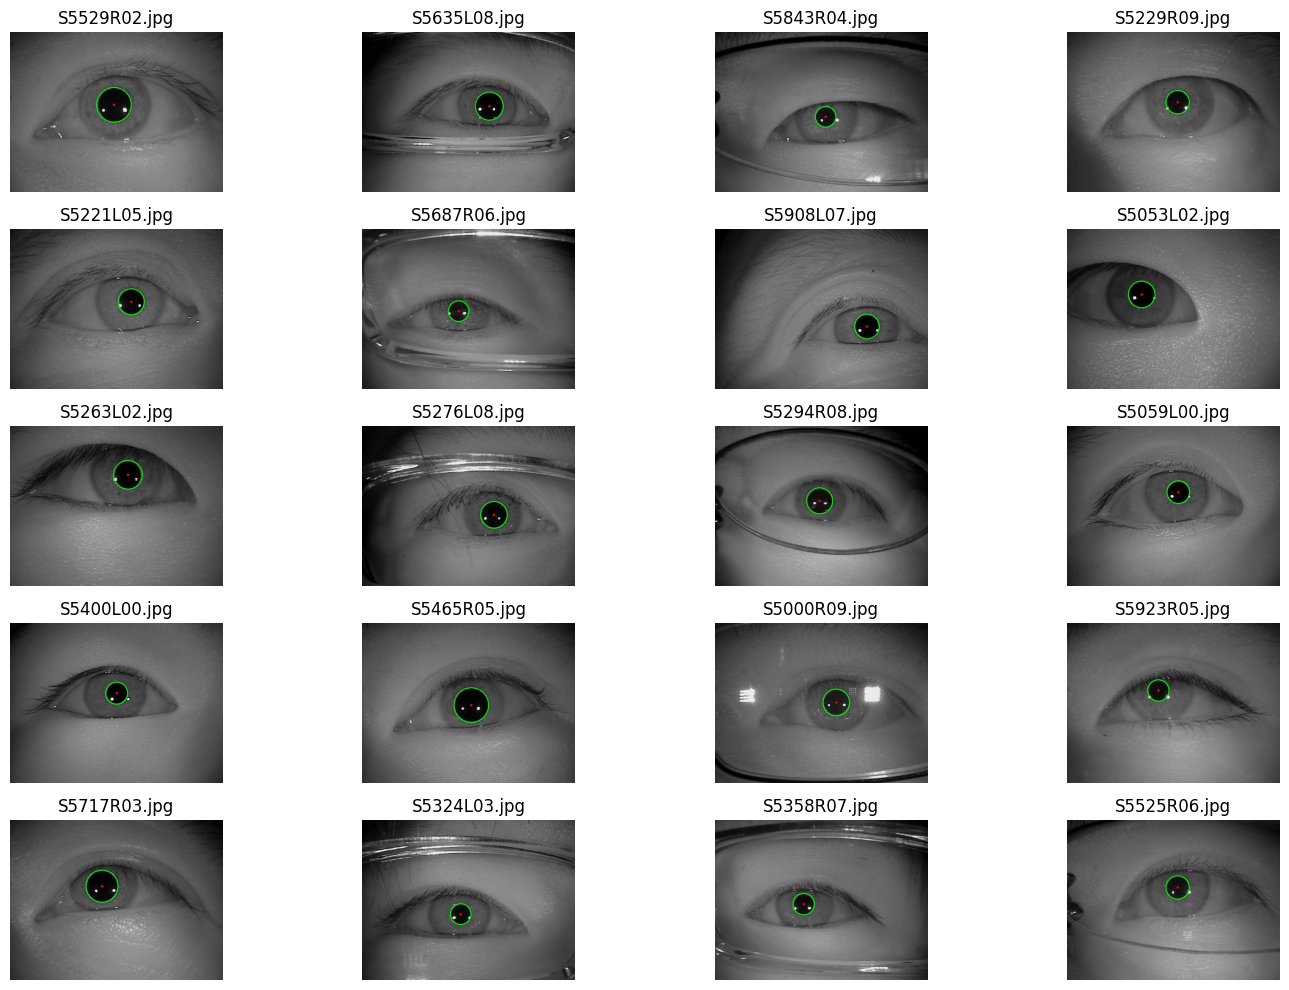

In [75]:
def visualize_pupils(directory, random_images=20):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    if len(image_files) < random_images:
        sample_files = image_files
    else:
        sample_files = random.sample(image_files, random_images)
    
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(sample_files):
        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
        
        plt.subplot(5, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_pupils(PUPIL_DATASET_DIR, random_images=20)

In [59]:
PUPIL_EPOCH = 6
PUPIL_BATCH = 32
PUPIL_STEPS_PER_EPOCH = math.ceil(len(iris_data[iris_data['pupil_detected']==1])*0.85 / PUPIL_BATCH)
PUPIL_VALIDATION_STEPS = math.ceil(len(iris_data[iris_data['pupil_detected']==1])*0.15 / PUPIL_BATCH)
SAVE_PUPIL_MODEL = os.path.join(SAVE_DIR, "pupil_model.h5")

#Splitting the data into 85% for training and 15% for validation

The pupil implementation below is based on the paper "An integrated neural network model for pupil detection and tracking – Lu Shi, ChangYuan Wang, Feng Tian, Hongbo Jia" (https://eprints.bournemouth.ac.uk/35772/1/LVCF_prepublish.pdf). The proposed approach, referred to as the VCF model, combines two key components:

__V-Net__: A modified encoder–decoder network that extracts multi-scale features from the input image through successive downsampling and upsampling, with skip connections to retain fine details.

__CF (Coordinate-Final) Block__: Inspired by object detection methods like YOLO, this block divides the image into a grid and predicts the pupil parameters (x and y offsets, and radius) for the grid cell that contains the pupil center, along with a confidence score indicating responsibility.

In [37]:
def custom_pupil_loss(y_true, y_pred):

    x_true = y_true[..., 0]
    y_true_ = y_true[..., 1]
    r_true = y_true[..., 2]
    resp_true = y_true[..., 3]
    
    x_pred = y_pred[..., 0]
    y_pred_ = y_pred[..., 1]
    r_pred = y_pred[..., 2]
    conf_pred = y_pred[..., 3]
    
    # Loss weights.
    lambda_coord = 5.0
    lambda_noobj = 0.5
    
    # Coordinate and radius loss (only for responsible cells).
    coord_loss = lambda_coord * resp_true * ((x_true - x_pred) ** 2 + (y_true_ - y_pred_) ** 2)
    radius_loss = lambda_coord * resp_true * ((r_true - r_pred) ** 2)
    
    # Confidence loss.
    conf_loss = resp_true * (1 - conf_pred) ** 2 + lambda_noobj * (1 - resp_true) * (conf_pred) ** 2
    
    total_loss = coord_loss + radius_loss + conf_loss
    return tf.reduce_mean(total_loss)

The custom loss function calculates the loss for pupil detection by comparing the true and predicted values for the pupil’s center coordinates, radius, and confidence. It applies a weighted loss depending on whether the cell is responsible for detecting the pupil or not. This helps the model focus on learning the correct position and size of the pupil, while also avoiding false positives. The total loss is a combination of the coordinate loss, radius loss, and confidence loss.

In [46]:
def pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640), grid_size=(7, 10), r_max=64, shuffle=True):
    df = iris_data[iris_data['pupil_detected'] == 1].copy().reset_index(drop=True)
    indices = np.arange(len(df))
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            batch_indices = indices[start:end]
            X_batch = []
            Y_batch = []
            
            grid_rows, grid_cols = grid_size
            img_h, img_w = image_size
            cell_h = img_h / grid_rows
            cell_w = img_w / grid_cols
            
            for i in batch_indices:
                row = df.iloc[i]
                img_path = row["OriginalPath"]
                image = cv2.imread(img_path)
                if image is None:
                    continue
                
                image = cv2.resize(image, (img_w, img_h))

                pupil_x = float(row['pupil_x'])
                pupil_y = float(row['pupil_y'])
                pupil_r = float(row['pupil_radius'])
                
                cell_row = int(pupil_y // cell_h)
                cell_col = int(pupil_x // cell_w)
                cell_row = min(cell_row, grid_rows - 1)
                cell_col = min(cell_col, grid_cols - 1)
                
                x_offset = (pupil_x - (cell_col * cell_w)) / cell_w
                y_offset = (pupil_y - (cell_row * cell_h)) / cell_h
                r_scaled = pupil_r / r_max

                target = np.zeros((grid_rows, grid_cols, 4), dtype=np.float32)
                target[cell_row, cell_col, :] = [x_offset, y_offset, r_scaled, 1.0]
                
                X_batch.append(image)
                Y_batch.append(target)
                            
            yield np.array(X_batch), np.array(Y_batch)

In [47]:
train_gen = pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640),
                                 grid_size=(7, 10), r_max=64, shuffle=True)
val_gen = pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640),
                               grid_size=(7, 10), r_max=64, shuffle=False)

We take a list of images and their pupil locations and generates batches for training the model. For each image, it divides the image into a grid and calculates where the pupil is located within that grid. It then generates a target grid with information about the pupil's position and radius. This allows the neural network to learn where the pupil is in each image. The function shuffles the data and processes it in batches for efficient training.

In [48]:
def center_mae_metric(y_true, y_pred):
    mask = y_true[..., 3:4]
    error = tf.abs(y_true[..., 0:2] - y_pred[..., 0:2])
    weighted_error = error * mask
    mae = tf.reduce_sum(weighted_error) / (tf.reduce_sum(mask) + 1e-6)
    return mae

This function calculates how far off the predicted pupil center coordinates (x, y) are from the true coordinates, but only for the cells where a pupil exists (indicated by the mask). The result is the MAE for the center prediction, showing how well the model is doing in detecting the pupil's position.

In [49]:
def radius_mae_metric(y_true, y_pred):
    mask = y_true[..., 3]
    error = tf.abs(y_true[..., 2] - y_pred[..., 2])
    weighted_error = error * mask
    mae = tf.reduce_sum(weighted_error) / (tf.reduce_sum(mask) + 1e-6)
    return mae

This function calculates the mean absolute error (MAE) between the predicted and actual pupil radius, but only for the cells where a pupil exists (indicated by the mask).

In [50]:
def euclidean_center_metric(y_true, y_pred):
    mask = y_true[..., 3:4]
    true_xy = y_true[..., 0:2] * mask
    pred_xy = y_pred[..., 0:2] * mask
    true_center = tf.reduce_sum(true_xy, axis=[1, 2])
    pred_center = tf.reduce_sum(pred_xy, axis=[1, 2])
    diff = true_center - pred_center
    dist = tf.sqrt(tf.reduce_sum(diff ** 2, axis=-1))
    return tf.reduce_mean(dist)

Euclidean distance between the true and predicted positions of the pupil center, considering only areas where the pupil is detected. The smaller the distance, the better the model has detected the correct pupil center. 

__MAE__ measures the average error (independently for x and y), while __Euclidean distance__ gives a more geometric, combined error between the predicted and true points.

In [51]:
def conv_block(x, filters, kernel_size=3, strides=1, padding='same'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

__Convolutional Block__

_Conv2D_: A 2D convolution layer that learns spatial patterns in the input images.

_BatchNormalization_: A layer that normalizes the activations to stabilize training.

_ReLU_: A Rectified Linear Unit activation function that introduces non-linearity.

It’s used multiple times to extract features from the input image. It’s a core component of both the encoder and decoder parts of the model.

In [52]:
def deconv_block(x, filters, kernel_size=2, strides=2, padding='same'):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

__Deconvolutional Block__

This block is used in the decoder part. It has the same structure as the convolutional block, but it uses a Conv2DTranspose layer to upsample the feature maps.It's responsible for "reversing" the pooling in the encoder, making the image resolution higher again. This helps in reconstructing the image after it has been processed through several layers.

In [53]:
def build_vcf_model(input_shape=(480, 640, 3), grid_size=(7, 10)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x1 = conv_block(inputs, 16, kernel_size=5)
    x1 = conv_block(x1, 16, kernel_size=3)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(x1)
    
    x2 = conv_block(p1, 32, kernel_size=3)
    x2 = conv_block(x2, 32, kernel_size=3)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(x2)
    
    # Bottleneck
    b = conv_block(p2, 64, kernel_size=3)
    b = conv_block(b, 64, kernel_size=3)
    
    # Decoder
    u1 = deconv_block(b, 32)
    u1 = layers.concatenate([u1, x2])
    u1 = conv_block(u1, 32, kernel_size=3)
    u1 = conv_block(u1, 32, kernel_size=3)
    
    u2 = deconv_block(u1, 16)
    u2 = layers.concatenate([u2, x1])
    u2 = conv_block(u2, 16, kernel_size=3)
    u2 = conv_block(u2, 16, kernel_size=3)
    
    # Reduce spatial dimensions to grid_size (7,10)
    grid_rows, grid_cols = grid_size
    stride_h = int(480 / grid_rows) 
    stride_w = int(640 / grid_cols)
    x3 = layers.Conv2D(64, kernel_size=3, strides=(stride_h, stride_w), padding='valid')(u2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.ReLU()(x3)

    
    # CF Head
    x4 = conv_block(x3, 64, kernel_size=3)
    x4 = conv_block(x4, 64, kernel_size=3)
    x4 = layers.Flatten()(x4)
    out_dim = grid_rows * grid_cols * 4
    x4 = layers.Dense(out_dim)(x4)
    outputs = layers.Reshape((grid_rows, grid_cols, 4))(x4)
    outputs = layers.Activation('sigmoid')(outputs)
    
    model = models.Model(inputs, outputs, name="Simple_VCF")
    return model

#### Architecture
1. __Encoder__:
Structure: The encoder consists of two conv blocks followed by max pooling layers. The pooling reduces the spatial dimensions of the image.
Function: The encoder extracts features and progressively reduces the image's resolution, capturing high-level abstractions.
2. __Bottleneck__:
Structure: The bottleneck consists of two conv blocks without any downsampling.
Function: This is the layer where the most abstract features are captured and the spatial dimensions are reduced to the smallest possible representation.
3. __Decoder__:
Structure: The decoder uses deconv blocks to upsample the image and restore its spatial resolution. Skip connections are used from the encoder to preserve fine details lost during downsampling.
Function: The decoder reconstructs the original input resolution by upsampling and adding the features extracted in the encoder part, improving the quality of the segmentation.
4. __Downsampling__:
The last convolution layer reduces the output to a grid with dimensions (7, 10), which corresponds to the grid_size (7 rows, 10 columns).
This is done using a Conv2D layer with strides calculated to reduce the output size appropriately.
5. __CF (Coordinate-Final)__:
Structure: After the final downsampling, the model has two more conv blocks followed by flattening and a dense layer.
Function: The dense layer is used to output the grid of predicted values (grid_size x grid_cols x 4 channels). These 4 channels represent the offsets (x, y), radius, and a responsible flag for each grid cell.
Activation: The sigmoid activation function is used to output probabilities, indicating the likelihood of each grid cell containing the pupil center.

In [56]:
pupil_model = build_vcf_model(input_shape=(480,640,3), grid_size=(7,10))
pupil_model.compile(optimizer='adam',
            metrics=[center_mae_metric, radius_mae_metric, euclidean_center_metric],
            loss=custom_pupil_loss)
pupil_model.summary()

Model: "Simple_VCF"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 480, 640, 16)         1216      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 480, 640, 16)         64        ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_30 (ReLU)             (None, 480, 640, 16)         0         ['batch_normalization

In [57]:
def train_model(pupil_model, train_gen, val_gen, epochs=PUPIL_EPOCH, steps_per_epoch=PUPIL_STEPS_PER_EPOCH, validation_steps=PUPIL_VALIDATION_STEPS, model_save_path=SAVE_PUPIL_MODEL):
    """
    Trains the model using generators.
    
    Parameters:
      model: Compiled Keras model.
      train_gen: Training data generator.
      val_gen: Validation data generator.
      epochs: Number of epochs.
      steps_per_epoch: Steps per epoch.
      validation_steps: Validation steps per epoch.
      model_save_path: File path to save the best model.
      
    Returns:
      history: Training history from model.fit.
    """
    checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=1, verbose=1)
    callbacks = [checkpoint, early_stop]
    
    history = pupil_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    return history

In [58]:
history = train_model(pupil_model, train_gen, val_gen, epochs=PUPIL_EPOCH, steps_per_epoch=PUPIL_STEPS_PER_EPOCH,
                      validation_steps=PUPIL_VALIDATION_STEPS, model_save_path=SAVE_PUPIL_MODEL)

Epoch 1/6
504/504 [==============================] - ETA: 0s - loss: 0.0091 - center_mae_metric: 0.1899 - radius_mae_metric: 0.1088 - euclidean_center_metric: 0.1497     
Epoch 1: val_loss improved from inf to 0.00455, saving model to pupil_model.h5


C:\Users\Gaming PC\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 10826s 21s/step - loss: 0.0091 - center_mae_metric: 0.1899 - radius_mae_metric: 0.1088 - euclidean_center_metric: 0.1497 - val_loss: 0.0046 - val_center_mae_metric: 0.1357 - val_radius_mae_metric: 0.0750 - val_euclidean_center_metric: 0.1067
Epoch 2/6
504/504 [==============================] - ETA: 0s - loss: 0.0026 - center_mae_metric: 0.1057 - radius_mae_metric: 0.0643 - euclidean_center_metric: 0.0835     
Epoch 2: val_loss improved from 0.00455 to 0.00235, saving model to pupil_model.h5
504/504 [==============================] - 10962s 22s/step - loss: 0.0026 - center_mae_metric: 0.1057 - radius_mae_metric: 0.0643 - euclidean_center_metric: 0.0835 - val_loss: 0.0023 - val_center_mae_metric: 0.1004 - val_radius_mae_metric: 0.0586 - val_euclidean_center_metric: 0.0798
Epoch 3/6
504/504 [==============================] - ETA: 0s - loss: 0.0019 - center_mae_metric: 0.0871 - radius_mae_metric: 0.0542 - euclidean_center_metric: 0.0687     
Epoch

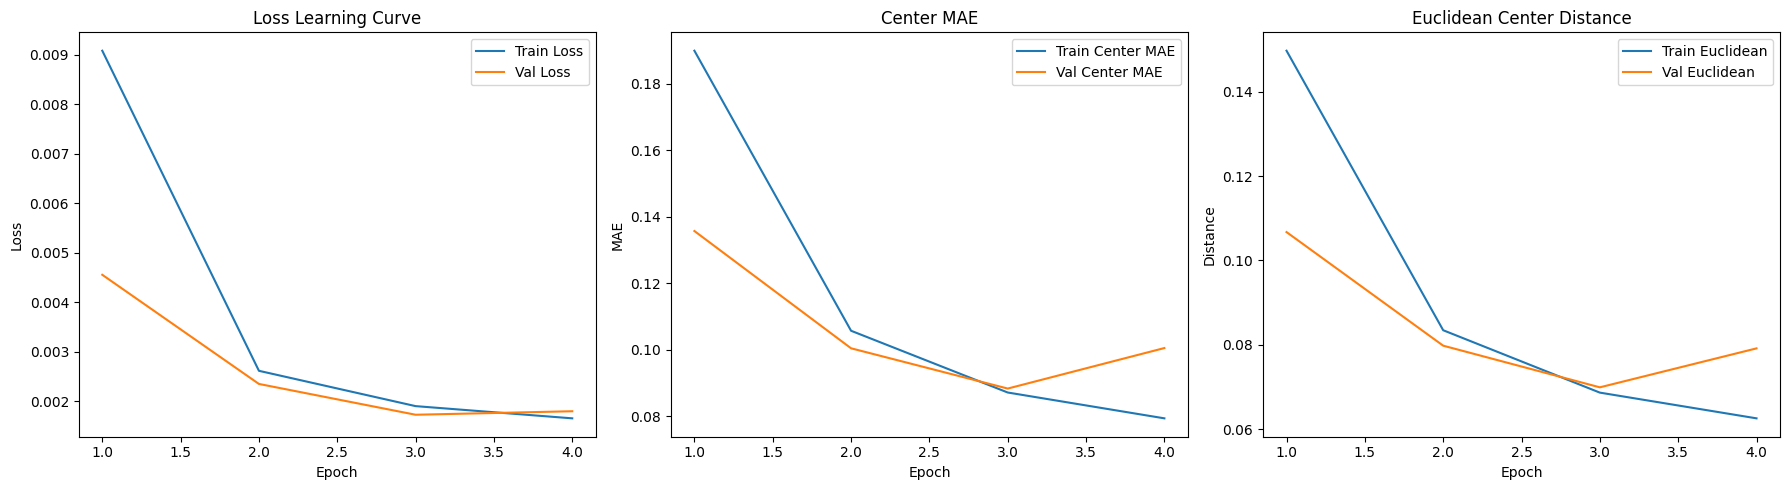

In [130]:
def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title('Loss Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Center MAE plot
    plt.subplot(1, 3, 2)
    if 'center_mae_metric' in history.history:
        plt.plot(epochs, history.history['center_mae_metric'], label='Train Center MAE')
        plt.plot(epochs, history.history['val_center_mae_metric'], label='Val Center MAE')
        plt.title('Center MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Center MAE not available", horizontalalignment='center')
    
    # Euclidean Distance plot
    plt.subplot(1, 3, 3)
    if 'euclidean_center_metric' in history.history:
        plt.plot(epochs, history.history['euclidean_center_metric'], label='Train Euclidean')
        plt.plot(epochs, history.history['val_euclidean_center_metric'], label='Val Euclidean')
        plt.title('Euclidean Center Distance')
        plt.xlabel('Epoch')
        plt.ylabel('Distance')
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Euclidean metric not available", horizontalalignment='center')
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

## Iris Recognition

### Data preparation

In [71]:
def predict_missing_pupils(model, iris_data, pred_dataset_dir, image_size=(480,640), grid_size=(7,10), r_max=64):
    """
    For every row in iris_data where pupil_detected==0, predicts the pupil parameters using the model,
    updates iris_data with predicted pupil_x, pupil_y, pupil_radius, and sets the PupilPath to the newly generated image path.
    
    Parameters:
      model: Trained Keras model.
      iris_data: DataFrame containing at least 'OriginalPath', 'PupilPath', 'pupil_x', 'pupil_y', 'pupil_radius', 'pupil_detected'.
      pred_dataset_dir: Directory where overlay images will be saved.
      image_size: Tuple (height, width) for model input.
      grid_size: Tuple (grid_rows, grid_cols) used in the model.
      r_max: Normalization factor used in the model training.
    
    Returns:
      Updated iris_data DataFrame.
    """
    import os
    import cv2
    import numpy as np
    
    os.makedirs(pred_dataset_dir, exist_ok=True)
    
    grid_rows, grid_cols = grid_size
    img_h, img_w = image_size
    cell_h = img_h / grid_rows
    cell_w = img_w / grid_cols
    
    for idx, row in iris_data[iris_data['pupil_detected'] == 0].iterrows():
        orig_path = row["OriginalPath"]
        image = cv2.imread(orig_path)
        if image is None:
            print(f"Image not found: {orig_path}")
            continue
        
        # Resize to the model input size.
        image_resized = cv2.resize(image, (img_w, img_h))
        input_tensor = np.expand_dims(image_resized, axis=0)  # shape (1,480,640,3)
        
        # Predict using the model with verbose=0.
        pred = model.predict(input_tensor, verbose=0)[0]  # shape (grid_rows, grid_cols, 4)
        
        # Find the responsible cell: choose cell with maximum confidence (channel index 3).
        confidence_map = pred[..., 3]
        cell_idx = np.unravel_index(np.argmax(confidence_map), confidence_map.shape)
        cell_row, cell_col = cell_idx
        
        # Get predicted normalized values from that cell.
        x_offset, y_offset, r_scaled, conf = pred[cell_row, cell_col, :]
        
        # Decode to absolute coordinates.
        pred_x = (cell_col + x_offset) * cell_w
        pred_y = (cell_row + y_offset) * cell_h
        pred_r = r_scaled * r_max
        
        # Update iris_data with the predicted parameters.
        iris_data.at[idx, 'pupil_x'] = pred_x
        iris_data.at[idx, 'pupil_y'] = pred_y
        iris_data.at[idx, 'pupil_radius'] = pred_r
        # We leave pupil_detected unchanged (or set to 0 if desired)
        # iris_data.at[idx, 'pupil_detected'] = 0  # Not updating as per instructions.
        
        # Create an overlay image with predictions drawn.
        overlay_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        cv2.circle(overlay_image, (int(pred_x), int(pred_y)), int(pred_r), (0, 255, 0), 2)
        cv2.circle(overlay_image, (int(pred_x), int(pred_y)), 2, (255, 0, 0), 3)
        
        # Save the overlay image.
        save_filename = os.path.basename(orig_path)
        save_path = os.path.join(pred_dataset_dir, save_filename)
        cv2.imwrite(save_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
        
        # Update the PupilPath column with the new overlay image path.
        iris_data.at[idx, 'PupilPath'] = save_path
    
    print("Images were predicted")
    return iris_data

# Example usage:
# PUPIL_PRED_DATASET_DIR = "./data/pupil_dataset_pred"
iris_data = predict_missing_pupils(model, iris_data, pred_dataset_dir=PUPIL_PRED_DATASET_DIR)

Images were predicted


In [72]:
iris_data.head(4)

Unnamed: 0  Label                                          ImagePath  \
0           0  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
1           1  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
2           2  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
3           3  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   

                                    OriginalPath  \
0  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   
2  ./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg   
3  ./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg   

                                 PupilPath    pupil_x    pupil_y pupil_radius  \
0  .//data/pupil_dataset_pred\S5437R06.jpg  354.87254  195.84486    30.555643   
1       .//data/pupil_dataset\S5437R09.jpg        308        168           38   
2       .//data/pupil_dataset\S5437R07.jpg        330        172           36   
3       .//data/pupil_dataset\S5437R02.jpg        336        246           32   

   pupil_detected  
0               0  
1               1  
2               1  
3               1

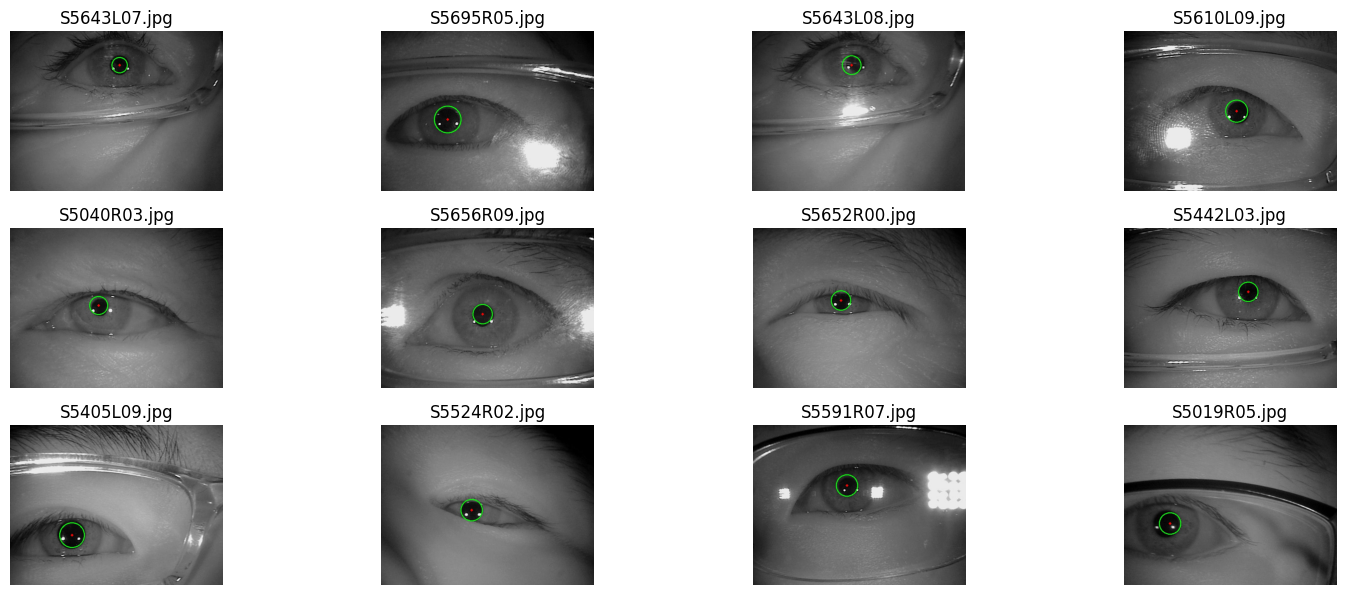

In [77]:
visualize_pupils(PUPIL_PRED_DATASET_DIR, random_images=12)

#### Image crop

In [78]:
def crop_image(image, center_x, center_y, crop_width, crop_height):
    """
    Crops the image with the specified width and height, centered at (center_x, center_y).
    Adjusts if the crop window exceeds image boundaries.
    """
    h, w = image.shape[:2]
    x1 = max(center_x - crop_width // 2, 0)
    y1 = max(center_y - crop_height // 2, 0)
    x2 = min(x1 + crop_width, w)
    y2 = min(y1 + crop_height, h)
    return image[y1:y2, x1:x2]

In [79]:
def crop_verified_images(iris_data, save_dir, crop_width=320, crop_height=240):
    """
    For every row in iris_data, uses the image at 'OriginalPath' and crops it
    so that the pupil center (pupil_x, pupil_y) is at the center of the cropped image.
    The cropped image is saved in save_dir and the new path is recorded in a new column 'WorkPath'.
    
    Parameters:
      iris_data: DataFrame containing 'OriginalPath', 'pupil_x', 'pupil_y', etc.
      save_dir: Directory where cropped images will be saved.
      crop_width: Width of the crop.
      crop_height: Height of the crop.
      
    Returns:
      Updated iris_data DataFrame with a new 'WorkPath' column.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize the WorkPath column if it doesn't exist.
    if "WorkPath" not in iris_data.columns:
        iris_data["WorkPath"] = ""
    
    for idx, row in iris_data.iterrows():
        orig_path = row["OriginalPath"]
        # Skip if the pupil coordinates are missing
        if pd.isnull(row["pupil_x"]) or pd.isnull(row["pupil_y"]):
            continue
        
        pupil_x = int(row["pupil_x"])
        pupil_y = int(row["pupil_y"])
        
        image = cv2.imread(orig_path)
        if image is None:
            continue
        
        # Crop the image with the pupil center as the crop center.
        cropped_image = crop_image(image, pupil_x, pupil_y, crop_width, crop_height)
        
        # Save the cropped image using the original file name.
        cropped_filename = os.path.basename(orig_path)
        cropped_path = os.path.join(save_dir, cropped_filename)
        cv2.imwrite(cropped_path, cropped_image)
        
        # Update the WorkPath column in the dataset.
        iris_data.at[idx, "WorkPath"] = cropped_path
    
    print(f"Processed {len(iris_data[iris_data['WorkPath'] != ''])} images. Cropped images saved in '{save_dir}'.")
    return iris_data

# Example usage:
WORK_DATASET_DIR = "./data/work_dataset"
iris_data = crop_verified_images(iris_data, WORK_DATASET_DIR, crop_width=320, crop_height=240)

Processed 20000 images. Cropped images saved in './data/work_dataset'.


In [83]:
iris_data.head(2)

Label                                   OriginalPath  \
0  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   

                                 PupilPath    pupil_x    pupil_y pupil_radius  \
0  .//data/pupil_dataset_pred\S5437R06.jpg  354.87254  195.84486    30.555643   
1       .//data/pupil_dataset\S5437R09.jpg        308        168           38   

   pupil_detected                          WorkPath  
0               0  ./data/work_dataset\S5437R06.jpg  
1               1  ./data/work_dataset\S5437R09.jpg

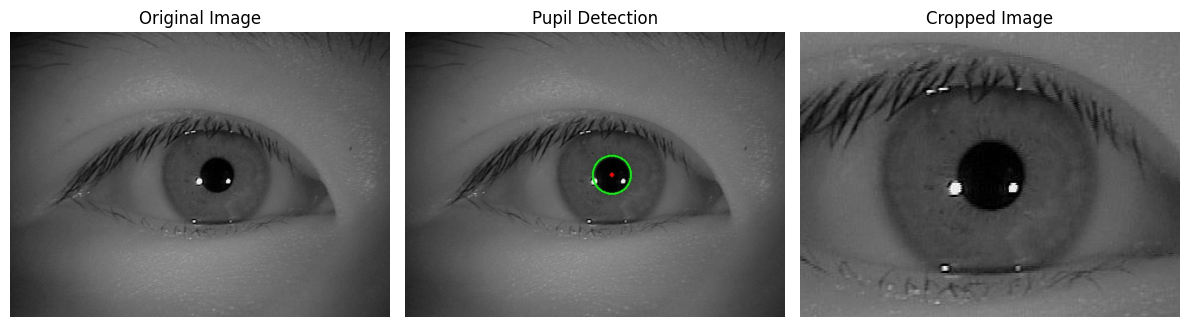

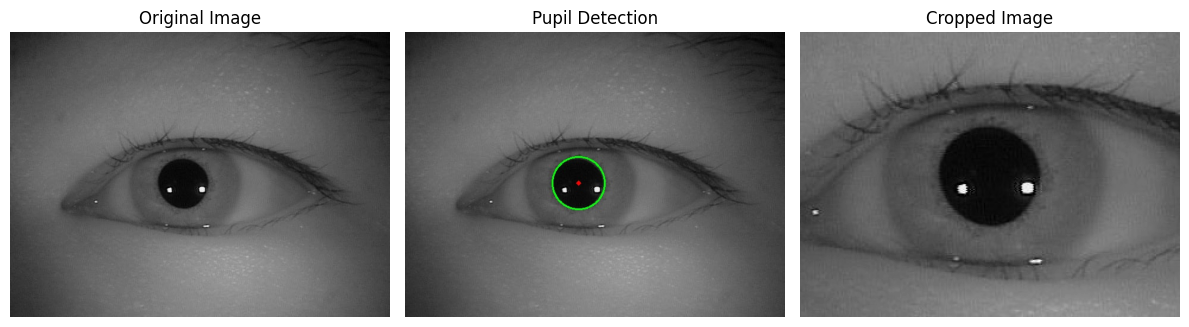

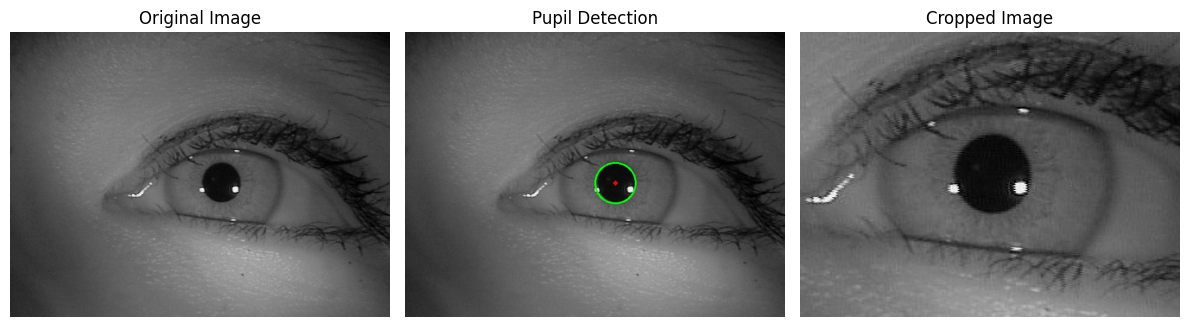

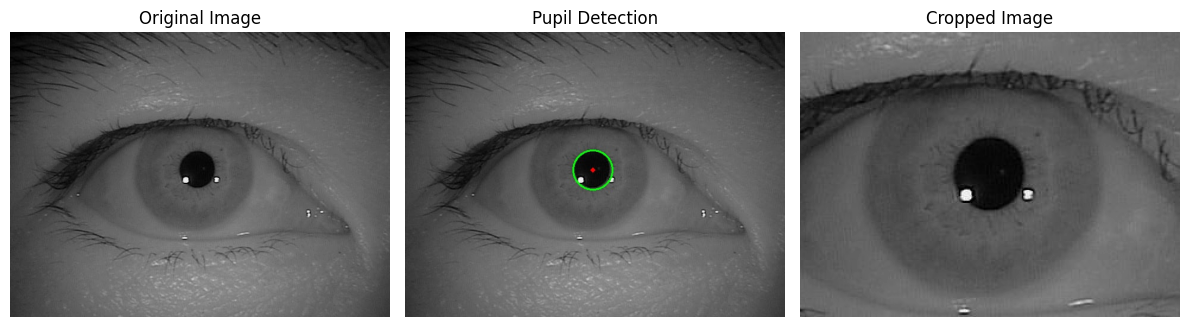

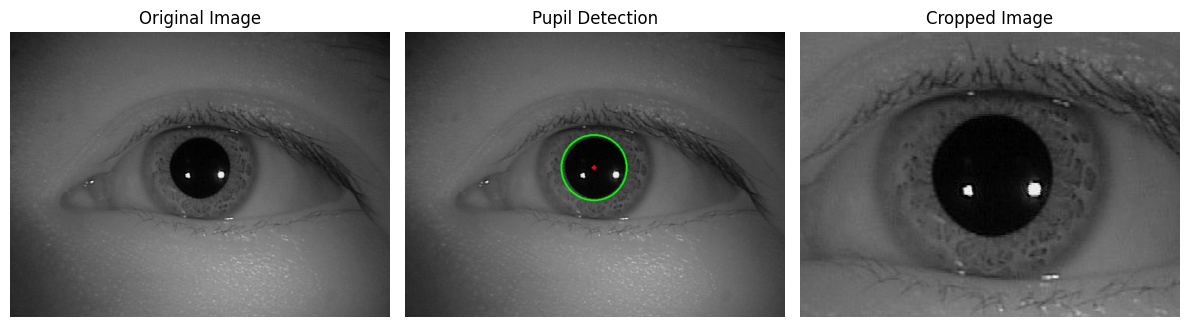

In [89]:
def visualize_random_rows(iris_data, random_images=5):
    sample_rows = iris_data.sample(n=random_images, random_state=42)
    
    for idx, row in sample_rows.iterrows():
        # Load images directly without existence checks.
        orig_path = row["OriginalPath"]
        pupil_path = row["PupilPath"]
        work_path = row["WorkPath"]
        
        original = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
        pupil_det = cv2.imread(pupil_path)
        pupil_det = cv2.cvtColor(pupil_det, cv2.COLOR_BGR2RGB)
        cropped = cv2.imread(work_path, cv2.IMREAD_GRAYSCALE)
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        ax[0].imshow(original, cmap="gray")
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        ax[1].imshow(pupil_det)
        ax[1].set_title("Pupil Detection")
        ax[1].axis("off")
        
        ax[2].imshow(cropped, cmap="gray")
        ax[2].set_title("Cropped Image")
        ax[2].axis("off")
        
        plt.tight_layout()
        plt.show()


visualize_random_rows(iris_data, random_images=5)

#### Image mask

In [114]:
def preprocess_mask(image_path):
    """
    Reads an image from image_path in grayscale, resizes it to TARGET_SIZE,
    normalizes it, and expands its dimensions.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, TARGET_SIZE)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

In [115]:
def generate_mask(image_path, save_path, model, pupil_r):
    """
    Uses the segmentation model to predict a mask for the image at image_path,
    then draws a black filled circle at the center (since the pupil is centered)
    with the given pupil_r, and saves the resulting mask as a .tiff file.
    
    Parameters:
      image_path: Path to the input image (from WorkPath).
      save_path: Path to save the mask.
      model: The segmentation model.
      pupil_r: Pupil radius (from iris_data).
    """
    img = preprocess_mask(image_path)
    img_batch = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img_batch, verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255

    # Remove channel dimension if present.
    if len(pred_mask.shape) == 3 and pred_mask.shape[2] == 1:
        pred_mask = pred_mask.squeeze(axis=-1)
    
    # Draw a black filled circle at the center of the image.
    center_x = TARGET_SIZE[0] // 2
    center_y = TARGET_SIZE[1] // 2
    cv2.circle(pred_mask, (center_x, center_y), int(pupil_r), 0, thickness=-1)
    
    cv2.imwrite(save_path, pred_mask)

In [116]:
def generate_all_masks(iris_data, save_mask_dir, model):
    """
    Iterates over each row in iris_data, uses the image at WorkPath to generate a mask,
    draws a black circle at the pupil location using the pupil_radius (assuming the pupil is centered),
    saves the mask as a .tiff file in save_mask_dir, and updates iris_data with the mask path in a new column 'MaskPath'.
    
    Parameters:
      iris_data: DataFrame containing 'WorkPath' and 'pupil_radius'.
      save_mask_dir: Directory where masks will be saved.
      model: The segmentation model.
    
    Returns:
      The updated iris_data DataFrame.
    """
    os.makedirs(save_mask_dir, exist_ok=True)
    
    # Create the new column if it doesn't exist.
    if "MaskPath" not in iris_data.columns:
        iris_data["MaskPath"] = ""
    
    for idx, row in iris_data.iterrows():
        image_path = row["WorkPath"]
        pupil_r = row["pupil_radius"]
        
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        mask_filename = base_name + ".jpg"
        mask_save_path = os.path.join(save_mask_dir, mask_filename)
        
        generate_mask(image_path, mask_save_path, model, pupil_r)
        iris_data.at[idx, "MaskPath"] = mask_save_path
    
    print(f"All masks saved in '{save_mask_dir}'")
    return iris_data

In [117]:
seg_model = tf.keras.models.load_model(SEG_MODEL, compile=False)

# Use the WorkPath images from iris_data to generate masks.
updated_iris_data = generate_all_masks(iris_data, MASK_DATASET_DIR, seg_model)

All masks saved in './data/mask_dataset/'


Label                                   OriginalPath  \
0      437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1      437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   
2      437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg   
3      437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg   
4      437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R03.jpg   
...      ...                                            ...   
19995  715-L  ./data/CASIA-Iris-Thousand/715\L\S5715L04.jpg   
19996  715-L  ./data/CASIA-Iris-Thousand/715\L\S5715L09.jpg   
19997  715-L  ./data/CASIA-Iris-Thousand/715\L\S5715L08.jpg   
19998  715-L  ./data/CASIA-Iris-Thousand/715\L\S5715L06.jpg   
19999  715-L  ./data/CASIA-Iris-Thousand/715\L\S5715L02.jpg   

                                     PupilPath    pupil_x    pupil_y  \
0      .//data/pupil_dataset_pred\S5437R06.jpg  354.87254  195.84486   
1           .//data/pupil_dataset\S5437R09.jpg        308        168   
2           .//data/pupil_dataset\S5437R07.jpg        330        172   
3           .//data/pupil_dataset\S5437R02.jpg        336        246   
4           .//data/pupil_dataset\S5437R03.jpg        314        206   
...                                        ...        ...        ...   
19995       .//data/pupil_dataset\S5715L04.jpg        364        246   
19996       .//data/pupil_dataset\S5715L09.jpg        332        228   
19997       .//data/pupil_dataset\S5715L08.jpg        374        238   
19998       .//data/pupil_dataset\S5715L06.jpg        394        246   
19999       .//data/pupil_dataset\S5715L02.jpg        338        174   

      pupil_radius  pupil_detected                          WorkPath  \
0        30.555643               0  ./data/work_dataset\S5437R06.jpg   
1               38               1  ./data/work_dataset\S5437R09.jpg   
2               36               1  ./data/work_dataset\S5437R07.jpg   
3               32               1  ./data/work_dataset\S5437R02.jpg   
4               45               1  ./data/work_dataset\S5437R03.jpg   
...            ...             ...                               ...   
19995           37               1  ./data/work_dataset\S5715L04.jpg   
19996           38               1  ./data/work_dataset\S5715L09.jpg   
19997           44               1  ./data/work_dataset\S5715L08.jpg   
19998           34               1  ./data/work_dataset\S5715L06.jpg   
19999           36               1  ./data/work_dataset\S5715L02.jpg   

                                MaskPath  
0      ./data/mask_dataset/S5437R06.tiff  
1      ./data/mask_dataset/S5437R09.tiff  
2      ./data/mask_dataset/S5437R07.tiff  
3      ./data/mask_dataset/S5437R02.tiff  
4      ./data/mask_dataset/S5437R03.tiff  
...                                  ...  
19995  ./data/mask_dataset/S5715L04.tiff  
19996  ./data/mask_dataset/S5715L09.tiff  
19997  ./data/mask_dataset/S5715L08.tiff  
19998  ./data/mask_dataset/S5715L06.tiff  
19999  ./data/mask_dataset/S5715L02.tiff  

[20000 rows x 9 columns]

In [118]:
iris_data.head(2)

Label                                   OriginalPath  \
0  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   

                                 PupilPath    pupil_x    pupil_y pupil_radius  \
0  .//data/pupil_dataset_pred\S5437R06.jpg  354.87254  195.84486    30.555643   
1       .//data/pupil_dataset\S5437R09.jpg        308        168           38   

   pupil_detected                          WorkPath  \
0               0  ./data/work_dataset\S5437R06.jpg   
1               1  ./data/work_dataset\S5437R09.jpg   

                            MaskPath  
0  ./data/mask_dataset/S5437R06.tiff  
1  ./data/mask_dataset/S5437R09.tiff

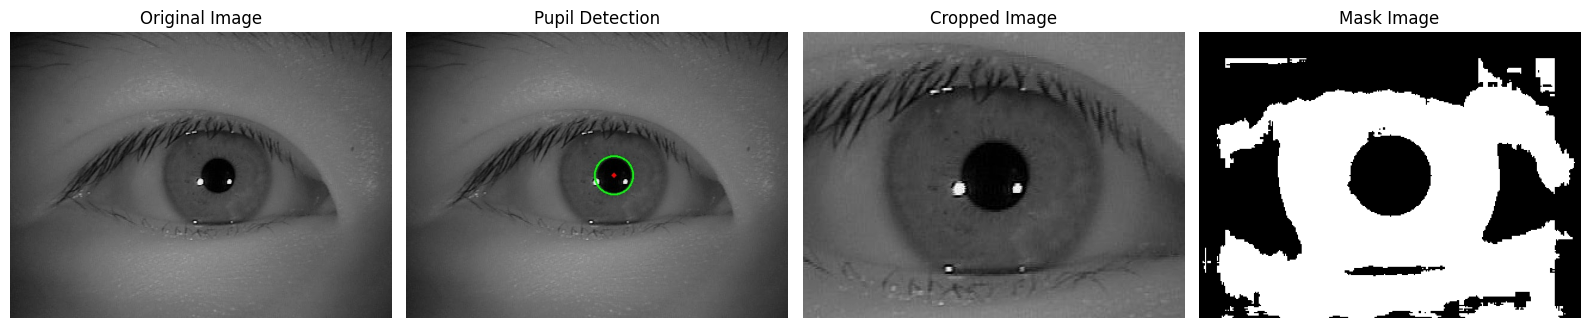

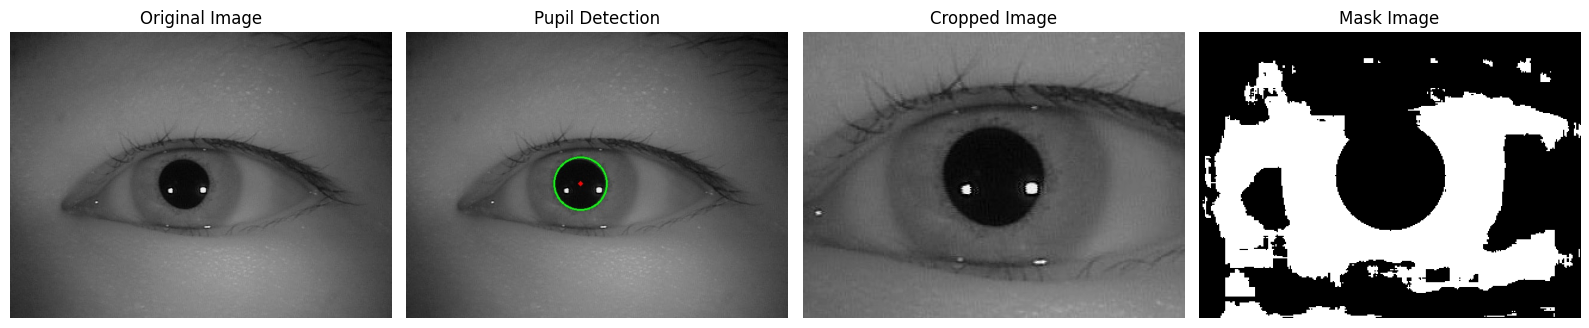

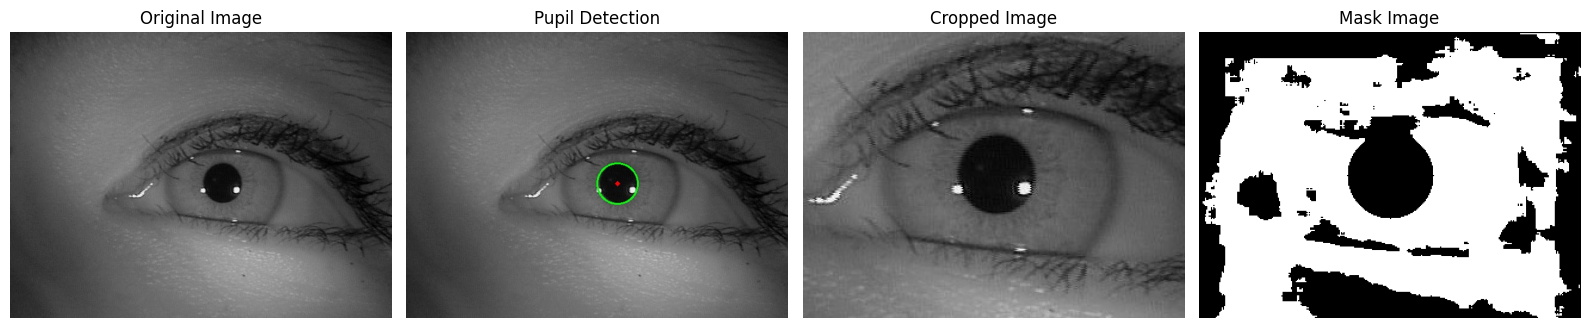

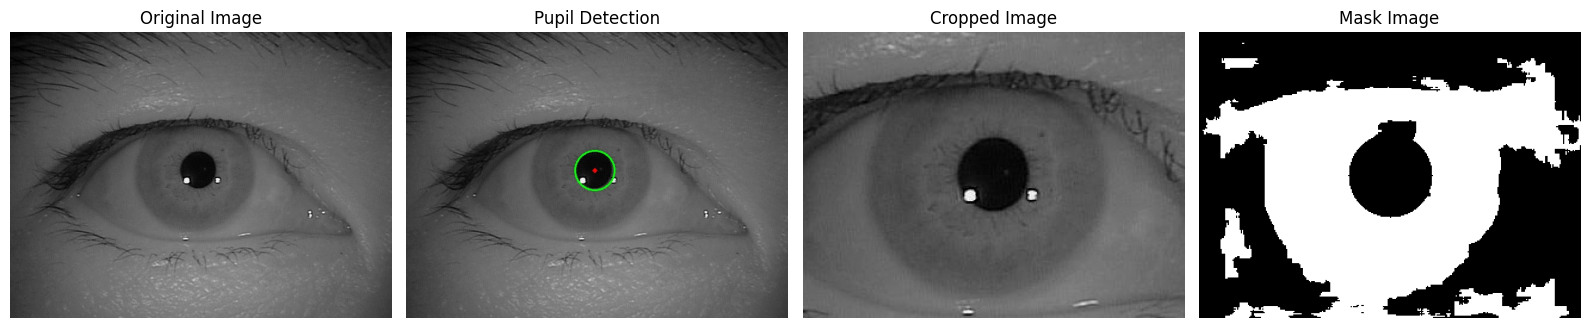

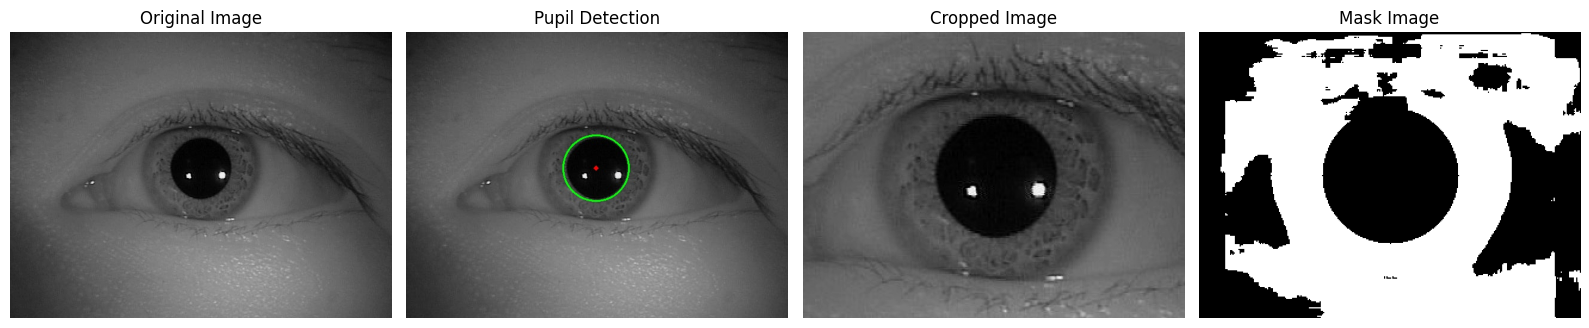

In [123]:
def visualize_random_mask_rows(iris_data, random_images=5):
    """
    Randomly selects `random_images` rows from iris_data and visualizes four images side-by-side:
      - Original Image (from OriginalPath)
      - Pupil Detection Image (from PupilPath)
      - Cropped Image (from WorkPath)
      - Mask Image (from MaskPath)
    
    Parameters:
      iris_data: DataFrame with columns 'OriginalPath', 'PupilPath', 'WorkPath', and 'MaskPath'.
      random_images: Number of random rows to display.
    """
    sample_rows = iris_data.sample(n=random_images, random_state=42)
    
    for idx, row in sample_rows.iterrows():
        # Load images without checking for existence.
        orig_path = row["OriginalPath"]
        pupil_path = row["PupilPath"]
        work_path = row["WorkPath"]
        mask_path = row["MaskPath"]
        
        original = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
        pupil_det = cv2.imread(pupil_path)
        pupil_det = cv2.cvtColor(pupil_det, cv2.COLOR_BGR2RGB)
        cropped = cv2.imread(work_path, cv2.IMREAD_GRAYSCALE)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        fig, ax = plt.subplots(1, 4, figsize=(16, 6))
        
        ax[0].imshow(original, cmap="gray")
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        ax[1].imshow(pupil_det)
        ax[1].set_title("Pupil Detection")
        ax[1].axis("off")
        
        ax[2].imshow(cropped, cmap="gray")
        ax[2].set_title("Cropped Image")
        ax[2].axis("off")
        
        ax[3].imshow(mask_img, cmap="gray")
        ax[3].set_title("Mask Image")
        ax[3].axis("off")
        
        plt.tight_layout()
        plt.show()

visualize_random_mask_rows(iris_data, random_images=5)

### Preprocessing

In [124]:
def label_to_int(label_str):
    """
    label_str is something like '437-R' or '437-L'
    We want to produce 4370 if it's '437-R', or 4371 if it's '437-L'.
    """
    subject_str, side = label_str.split("-")  # e.g. ("437", "R")
    
    subject_id = int(subject_str)  # convert "437" to integer 437
    if side == 'R':
        return subject_id * 10       # e.g., 437 -> 4370
    elif side == 'L':
        return subject_id * 10 + 1   # e.g., 437 -> 4371
    else:
        raise ValueError(f"Unexpected side: {side} in label {label_str}")

In [129]:
def fix_labels(iris_df):
    """
    Creates a new column 'LabelIndex' from 'Label', converting strings like '437-R' to integers
    (e.g. 4370 or 4371) using label_to_int. Returns the updated DataFrame.
    """
    iris_df["LabelIndex"] = iris_df["Label"].apply(label_to_int)
    return iris_df

iris_data = fix_labels(iris_data)  
iris_data.tail(3)

Label                                   OriginalPath  \
19997  715-L  ./data/CASIA-Iris-Thousand/715\L\S5715L08.jpg   
19998  715-L  ./data/CASIA-Iris-Thousand/715\L\S5715L06.jpg   
19999  715-L  ./data/CASIA-Iris-Thousand/715\L\S5715L02.jpg   

                                PupilPath pupil_x pupil_y pupil_radius  \
19997  .//data/pupil_dataset\S5715L08.jpg     374     238           44   
19998  .//data/pupil_dataset\S5715L06.jpg     394     246           34   
19999  .//data/pupil_dataset\S5715L02.jpg     338     174           36   

       pupil_detected                          WorkPath  \
19997               1  ./data/work_dataset\S5715L08.jpg   
19998               1  ./data/work_dataset\S5715L06.jpg   
19999               1  ./data/work_dataset\S5715L02.jpg   

                                MaskPath  LabelIndex  
19997  ./data/mask_dataset/S5715L08.tiff        7151  
19998  ./data/mask_dataset/S5715L06.tiff        7151  
19999  ./data/mask_dataset/S5715L02.tiff        7151

In [15]:
iris_data = pd.read_csv("./iris_dataset.csv")
iris_data.head(2)

Label                                   OriginalPath  \
0  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   

                                 PupilPath    pupil_x    pupil_y  \
0  .//data/pupil_dataset_pred\S5437R06.jpg  354.87254  195.84486   
1       .//data/pupil_dataset\S5437R09.jpg  308.00000  168.00000   

   pupil_radius  pupil_detected                          WorkPath  \
0     30.555643               0  ./data/work_dataset\S5437R06.jpg   
1     38.000000               1  ./data/work_dataset\S5437R09.jpg   

                            MaskPath  LabelIndex  
0  ./data/mask_dataset/S5437R06.tiff        4370  
1  ./data/mask_dataset/S5437R09.tiff        4370

In [33]:
def map_label(label_str):
    subject_str, side = label_str.split("-")
    subject_id = int(subject_str)
    if side == 'R':
        return subject_id * 2
    elif side == 'L':
        return subject_id * 2 + 1
    else:
        raise ValueError(f"Unexpected side: {side} in label {label_str}")

def remap_labels(iris_df):
    iris_df["MappedLabel"] = iris_df["Label"].apply(map_label)
    return iris_df

iris_data = remap_labels(iris_data)
print(iris_data[["Label", "MappedLabel"]].head())

In [34]:
def remap_labels(iris_df):
    iris_df["MappedLabel"] = iris_df["Label"].apply(map_label)
    return iris_df

iris_data = remap_labels(iris_data)
print(iris_data[["Label", "MappedLabel"]].head())

   Label  MappedLabel
0  437-R          874
1  437-R          874
2  437-R          874
3  437-R          874
4  437-R          874


### Model

In [36]:
EPOCH_REC = 32
BATCH_REC = 24
WIDTH_REC = 160
HIGH_REC = 120

In [226]:
def stratified_split(df, label_col="LabelIndex", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """
    Stratified split ensuring each label has the same proportion 
    across train, val, test. NO CHANGE from previous.
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-8, "Ratios must sum to 1."

    train_rows, val_rows, test_rows = [], [], []
    random.seed(seed)

    unique_labels = df[label_col].unique()

    for label in unique_labels:
        label_df = df[df[label_col] == label]
        label_data = list(label_df.itertuples(index=False))
        random.shuffle(label_data)

        n = len(label_data)
        n_train = int(n * train_ratio)
        n_val   = int(n * val_ratio)
        
        train_part = label_data[:n_train]
        val_part   = label_data[n_train:n_train + n_val]
        test_part  = label_data[n_train + n_val:]

        train_rows.extend(train_part)
        val_rows.extend(val_part)
        test_rows.extend(test_part)

    train_df = pd.DataFrame(train_rows, columns=df.columns)
    val_df   = pd.DataFrame(val_rows,   columns=df.columns)
    test_df  = pd.DataFrame(test_rows,  columns=df.columns)
    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_split(iris_data, label_col="LabelIndex")

In [227]:
def build_class_dict(iris_df, use_mask=False):
    """
    Builds a dictionary mapping each label (LabelIndex)
    to a list of image file paths.

    If use_mask=False, uses the 'WorkPath' column.
    If use_mask=True, uses the 'MaskPath' column.
    """
    class_dict = defaultdict(list)

    for _, row in iris_df.iterrows():
        label_idx = row["LabelIndex"]
        
        if use_mask:
            img_path = row["MaskPath"]
        else:
            img_path = row["WorkPath"]
        
        # Skip invalid or missing paths
        if not isinstance(img_path, str) or not os.path.exists(img_path):
            continue
        
        class_dict[label_idx].append(img_path)
    
    return dict(class_dict)

train_dict = build_class_dict(train_df, use_mask=False)
val_dict   = build_class_dict(val_df,   use_mask=False)

In [228]:
def load_and_preprocess_image(path, target_size=(HIGH_REC,WIDTH_REC)):
    """
    Loads an image in grayscale, resizes, normalizes to [0,1].
    Returns shape (240,320,1).
    NO CHANGE from previous design, only rename for clarity.
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (target_size[1], target_size[0]))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    return img


In [229]:
def get_siamese_batch_koch(
    class_dict, batch_size=BATCH_REC, pos_ratio=0.5, target_size=(HIGH_REC,WIDTH_REC)
):
    """
    Creates a single batch of pairs (imgA, imgB) + label (0/1).
    Inspired by 'Siamese Neural Networks for One-shot Image Recognition'.
    
    - pos_ratio fraction of pairs are positive (same label).
    - rest are negative.
    """
    labels_list = list(class_dict.keys())
    num_pos = int(batch_size * pos_ratio)
    num_neg = batch_size - num_pos

    batchA, batchB, batch_labels = [], [], []

    # Positive pairs
    for _ in range(num_pos):
        c = random.choice(labels_list)
        paths = class_dict[c]
        if len(paths) < 2:
            continue  # skip if not enough images
        p1, p2 = random.sample(paths, 2)
        imgA = load_and_preprocess_image(p1, target_size)
        imgB = load_and_preprocess_image(p2, target_size)
        if (imgA is None) or (imgB is None):
            continue
        batchA.append(imgA)
        batchB.append(imgB)
        batch_labels.append(1)

    # Negative pairs
    for _ in range(num_neg):
        c1, c2 = random.sample(labels_list, 2)
        p1 = random.choice(class_dict[c1])
        p2 = random.choice(class_dict[c2])
        imgA = load_and_preprocess_image(p1, target_size)
        imgB = load_and_preprocess_image(p2, target_size)
        if (imgA is None) or (imgB is None):
            continue
        batchA.append(imgA)
        batchB.append(imgB)
        batch_labels.append(0)

    batchA = np.array(batchA, dtype=np.float32)
    batchB = np.array(batchB, dtype=np.float32)
    batch_labels = np.array(batch_labels, dtype=np.int32)

    return batchA, batchB, batch_labels


In [230]:
def siamese_pair_generator_koch(
    class_dict, batch_size=BATCH_REC, pos_ratio=0.5, target_size=(HIGH_REC,WIDTH_REC)
):
    """
    A generator that yields ([batchA, batchB], batch_labels) indefinitely.
    Reflects the Koch et al. approach by random pair sampling each time.
    """
    while True:
        imgA, imgB, labels = get_siamese_batch_koch(
            class_dict,
            batch_size=batch_size,
            pos_ratio=pos_ratio,
            target_size=target_size
        )
        yield ([imgA, imgB], labels)

gen_train = siamese_pair_generator_koch(train_dict, batch_size=BATCH_REC, pos_ratio=0.5)
gen_val   = siamese_pair_generator_koch(val_dict,   batch_size=BATCH_REC, pos_ratio=0.5)

In [231]:
def build_embedding(input_shape=(240,320,1)):
    """
    A much lighter CNN: fewer conv filters, smaller kernels.
    This drastically cuts parameter counts.
    """
    from tensorflow.keras import layers, Model
    
    inp = layers.Input(shape=input_shape)
    
    # Example: small kernel sizes, fewer filters
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)  # e.g. 120×160
    
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)  # 60×80
    
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)  # 30×40
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)  # smaller final layer
    # No big 4096-len layer
    model = Model(inp, x, name="embedding_lite")
    return model

In [232]:
def build_siamese(input_shape=(240,320,1)):
    """
    Siamese model with drastically fewer parameters.
    """
    import tensorflow as tf
    from tensorflow.keras import layers, Model

    embedding_net = build_embedding(input_shape)

    inputA = layers.Input(shape=input_shape)
    inputB = layers.Input(shape=input_shape)

    featA = embedding_net(inputA)
    featB = embedding_net(inputB)

    # L1 distance
    diff = layers.Lambda(lambda t: tf.math.abs(t[0] - t[1]))([featA, featB])
    
    # Final small FC => 1 output
    output = layers.Dense(1, activation='sigmoid')(diff)
    
    model = Model([inputA, inputB], output, name="siamese_lite")
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',]
    )
    return model

In [233]:
model_rec = build_siamese(input_shape=(HIGH_REC, WIDTH_REC, 1))
model_rec.summary()  # Add this line

Model: "siamese_lite"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 120, 160, 1)]        0         []                            
                                                                                                  
 input_42 (InputLayer)       [(None, 120, 160, 1)]        0         []                            
                                                                                                  
 embedding_lite (Functional  (None, 128)                  2481024   ['input_41[0][0]',            
 )                                                                   'input_42[0][0]']            
                                                                                                  
 lambda_12 (Lambda)          (None, 128)                  0         ['embedding_lite[0]

In [234]:
history_rec = model_rec.fit(
    gen_train,
    steps_per_epoch=1000,
    validation_data=gen_val,
    validation_steps=200,
    epochs=EPOCH_REC,
    callbacks=[get_early_stopping_callback()]
)

Epoch 1/32
1000/1000 [==============================] - 3549s 4s/step - loss: 0.4409 - accuracy: 0.8033 - val_loss: 0.2327 - val_accuracy: 0.8829
Epoch 2/32
1000/1000 [==============================] - 3580s 4s/step - loss: 0.3062 - accuracy: 0.8873 - val_loss: 0.2447 - val_accuracy: 0.8817
Epoch 3/32
1000/1000 [==============================] - 3583s 4s/step - loss: 0.2526 - accuracy: 0.9077 - val_loss: 0.1780 - val_accuracy: 0.9192
Epoch 4/32
1000/1000 [==============================] - 3583s 4s/step - loss: 0.2178 - accuracy: 0.9225 - val_loss: 0.1702 - val_accuracy: 0.9237
Epoch 5/32
1000/1000 [==============================] - 3578s 4s/step - loss: 0.1915 - accuracy: 0.9310 - val_loss: 0.1898 - val_accuracy: 0.9142
Epoch 6/32
1000/1000 [==============================] - 3546s 4s/step - loss: 0.1739 - accuracy: 0.9383 - val_loss: 0.2006 - val_accuracy: 0.9067


In [63]:
import os
import cv2

# Directories containing the images
work_dir = "./data/work_dataset/"
mask_dir = "./data/mask_dataset/"

# Expected image size
expected_size = (240, 240)

def check_image_sizes(directory):
    incorrect_images = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            incorrect_images.append((filename, "File not found or unreadable"))
            continue

        if image.shape[:2] != expected_size:
            incorrect_images.append((filename, image.shape[:2]))

    return incorrect_images

# Check both directories
incorrect_work_images = check_image_sizes(work_dir)
incorrect_mask_images = check_image_sizes(mask_dir)

# Display results
incorrect_images = {
    "Incorrect Work Images": incorrect_work_images,
    "Incorrect Mask Images": incorrect_mask_images
}

import pandas as pd
df_results = pd.DataFrame([(k, v[0], v[1]) for k, lst in incorrect_images.items() for v in lst], 
                          columns=["Directory", "Filename", "Incorrect Size"])

import pandas as pd

# Assuming `df_results` contains image paths and sizes
if not df_results.empty:
    print("⚠️ Incorrect Image Sizes Found:")
    print(df_results.to_string(index=False))
else:
    print("✅ All images are correctly sized (240x240).")

⚠️ Incorrect Image Sizes Found:
            Directory     Filename Incorrect Size
Incorrect Work Images S5009R07.jpg     (238, 240)
Incorrect Work Images S5017L05.jpg     (230, 240)
Incorrect Work Images S5025R06.jpg     (202, 240)
Incorrect Work Images S5036R04.jpg     (212, 240)
Incorrect Work Images S5039R06.jpg     (194, 240)
Incorrect Work Images S5059R09.jpg     (206, 240)
Incorrect Work Images S5071L05.jpg     (226, 240)
Incorrect Work Images S5075R04.jpg     (236, 240)
Incorrect Work Images S5092R03.jpg     (220, 240)
Incorrect Work Images S5095L03.jpg     (238, 240)
Incorrect Work Images S5095L04.jpg     (238, 240)
Incorrect Work Images S5095R05.jpg     (216, 240)
Incorrect Work Images S5096L00.jpg     (240, 234)
Incorrect Work Images S5102L02.jpg     (218, 240)
Incorrect Work Images S5123L01.jpg     (240, 238)
Incorrect Work Images S5144R05.jpg     (214, 240)
Incorrect Work Images S5197R05.jpg     (226, 240)
Incorrect Work Images S5201L00.jpg     (238, 240)
Incorrect Work Ima

In [83]:
def map_label(label_str):
    subject_str, side = label_str.split("-")
    subject_id = int(subject_str)
    if side == 'R':
        return subject_id * 2
    elif side == 'L':
        return subject_id * 2 + 1
    else:
        raise ValueError(f"Unexpected side: {side} in label {label_str}")
    

def remap_labels(iris_df):
    """
    Maps string labels in 'Label' column to sequential integers (0 to num_classes - 1).
    Ensures labels are mapped without gaps.
    """
    unique_labels = sorted(iris_df["Label"].astype(str).unique())  # Convert labels to string to avoid dtype issues
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}  # Create mapping dict
    
    iris_df["MappedLabel"] = iris_df["Label"].map(label_mapping).astype(int)  # Ensure integer labels

    return iris_df, label_mapping

In [84]:
iris_data, label_mapping = remap_labels(iris_data)
for label, mapped in list(label_mapping.items())[:6]:
    print(f"'{label}': {mapped}")

'000-L': 0
'000-R': 1
'001-L': 2
'001-R': 3
'002-L': 4
'002-R': 5


### ResNet model

In [100]:
BATCH_RNN = 8
EPOCH_RNN = 40
SQUARE_RNN = 240

In [101]:
import cv2
import numpy as np

def pad_to_square(image, target_size=(SQUARE_RNN, SQUARE_RNN)):
    """
    Adds padding to make the image exactly 240x240.
    If the image is smaller in any dimension, it pads evenly on both sides.
    """
    h, w = image.shape[:2]
    target_h, target_w = target_size

    if h == target_h and w == target_w:
        return image  # Already correct size

    # Calculate padding needed
    pad_top = max(0, (target_h - h) // 2)
    pad_bottom = max(0, target_h - h - pad_top)
    pad_left = max(0, (target_w - w) // 2)
    pad_right = max(0, target_w - w - pad_left)

    # Apply padding (using constant value of 0, assuming grayscale)
    padded_image = cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right,
                                      borderType=cv2.BORDER_CONSTANT, value=0)
    return padded_image

In [102]:
def early_stopping_callback():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    )

In [103]:
def create_dataset(iris_df, use_mask=False):
    X, Y = [], []
    img_col = "MaskPath" if use_mask else "WorkPath"  # Select the correct column

    for _, row in iris_df.iterrows():
        img_path = row[img_col]
        if not isinstance(img_path, str) or not os.path.exists(img_path):
            continue
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue  # Skip unreadable images
        
        # Ensure the image is 240x240
        if image.shape != (SQUARE_RNN, SQUARE_RNN):  
            image = cv2.resize(image, (SQUARE_RNN, SQUARE_RNN))

        image = image.astype(np.float32) / 255.0  # Normalize
        image = np.expand_dims(image, axis=-1)  # Ensure correct shape (240,240,1)

        X.append(image)
        Y.append(row["MappedLabel"])

    if not X:
        raise ValueError("❌ No valid images found! Check preprocessing.")

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.int64)


In [104]:
def stratified_split(df, label_col="MappedLabel", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-8, "Ratios must sum to 1."

    train_rows, val_rows, test_rows = [], [], []
    random.seed(seed)

    unique_labels = df[label_col].unique()
    
    for label in unique_labels:
        label_df = df[df[label_col] == label]
        label_data = list(label_df.itertuples(index=False))
        random.shuffle(label_data)
        
        n = len(label_data)
        n_train = int(n * train_ratio)
        n_val   = int(n * val_ratio)
        
        train_part = label_data[:n_train]
        val_part   = label_data[n_train:n_train + n_val]
        test_part  = label_data[n_train + n_val:]
        
        train_rows.extend(train_part)
        val_rows.extend(val_part)
        test_rows.extend(test_part)
    
    train_df = pd.DataFrame(train_rows, columns=df.columns)
    val_df   = pd.DataFrame(val_rows,   columns=df.columns)
    test_df  = pd.DataFrame(test_rows,  columns=df.columns)
    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_split(iris_data, label_col="MappedLabel")
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 16000
Validation size: 2000
Test size: 2000


In [105]:
def augment_image(img):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    
    if random.random() < 0.1:
        img_tensor = tf.image.flip_left_right(img_tensor)
    
    if random.random() < 0.1:
        img_tensor = tf.image.flip_up_down(img_tensor)
    
    if random.random() < 0.01:
        img_tensor = tf.image.random_brightness(img_tensor, max_delta=0.2)
    
    if random.random() < 0.1:
        noise = tf.random.normal(shape=tf.shape(img_tensor), mean=0.0, stddev=0.05)
        img_tensor = img_tensor + noise
        img_tensor = tf.clip_by_value(img_tensor, 0.0, 1.0)
    
    if random.random() < 0.1:
        img_np = img_tensor.numpy()
        img_np = np.squeeze(img_np, axis=-1)
        ksize = random.choice([3, 5])
        img_np = cv2.GaussianBlur(img_np, (ksize, ksize), 0)
        img_np = np.expand_dims(img_np, axis=-1)
        img_tensor = tf.convert_to_tensor(img_np, dtype=tf.float32)
    
    return img_tensor.numpy()

In [106]:
def data_generator(iris_df, use_mask=False, target_size=(SQUARE_RNN, SQUARE_RNN), batch_size=32, augment=False):
    img_col = "MaskPath" if use_mask else "WorkPath"
    rows = iris_df.to_dict('records')
    
    while True:
        random.shuffle(rows)
        batch_images = []
        batch_labels = []
        for row in rows:
            img_path = row[img_col]
            if not isinstance(img_path, str) or not os.path.exists(img_path):
                continue
            
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            
            # Ensure image is correctly padded to 240x240
            image = pad_to_square(image, target_size=target_size)

            image = image.astype(np.float32) / 255.0
            image = np.expand_dims(image, axis=-1)

            if augment:
                image = augment_image(image)
            
            batch_images.append(image)
            batch_labels.append(row["MappedLabel"])
            
            if len(batch_images) == batch_size:
                yield np.array(batch_images, dtype=np.float32), np.array(batch_labels, dtype=np.int64)
                batch_images, batch_labels = [], []

In [107]:
train_gen_rnn = data_generator(train_df, use_mask=False, batch_size=BATCH_RNN, augment=True)
val_gen_rnn = data_generator(val_df, use_mask=False, batch_size=BATCH_RNN, augment=False)

In [108]:
def residual_block(inputs, filters, kernel_size=3, stride=1):
    """
    Basic residual block with two convolutional layers.
    Adjusts the shortcut via a 1x1 convolution if input shape does not match.
    """
    from tensorflow.keras import layers
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [109]:
def build_resnet_classifier(input_shape=(HEIGHT_RNN, WIDTH_RNN, 1), num_classes=2000):
    from tensorflow.keras import layers
    from tensorflow.keras.models import Model  # Import Model here
    
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution: 7x7 kernel, 64 filters, stride 2.
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Max pooling: 3x3, stride 2.
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    
    # Group 1: 2 residual blocks with 64 filters.
    x = residual_block(x, filters=64, kernel_size=3, stride=1)
    x = residual_block(x, filters=64, kernel_size=3, stride=1)
    
    # Group 2: 2 residual blocks with 128 filters (first block downsamples with stride 2).
    x = residual_block(x, filters=128, kernel_size=3, stride=2)
    x = residual_block(x, filters=128, kernel_size=3, stride=1)
    
    # Group 3: 2 residual blocks with 256 filters (first block downsamples with stride 2).
    x = residual_block(x, filters=256, kernel_size=3, stride=2)
    x = residual_block(x, filters=256, kernel_size=3, stride=1)
    
    # Group 4: 2 residual blocks with 512 filters (first block downsamples with stride 2).
    x = residual_block(x, filters=512, kernel_size=3, stride=2)
    x = residual_block(x, filters=512, kernel_size=3, stride=1)
    
    # Global average pooling and final Dense layer for classification.
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [110]:
model_rnn = build_resnet_classifier(input_shape=(SQUARE_RNN,SQUARE_RNN,1), num_classes=len(train_df["MappedLabel"].unique()))
model_rnn.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d_136 (Conv2D)         (None, 120, 120, 64)         3136      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_136 (B  (None, 120, 120, 64)         256       ['conv2d_136[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_118 (ReLU)            (None, 120, 120, 64)         0         ['batch_normalization_13

In [111]:
steps_per_epoch_rnn = math.ceil(len(train_df) / BATCH_RNN)
validation_steps_rnn = math.ceil(len(val_df) / BATCH_RNN)

history_rnn = model_rnn.fit(
    train_gen_rnn,
    steps_per_epoch=steps_per_epoch_rnn,
    validation_data=val_gen_rnn,
    validation_steps=validation_steps_rnn,
    epochs=EPOCH_RNN,
    callbacks=[early_stopping_callback()]
)

Epoch 1/40
 192/2000 [=>............................] - ETA: 17:51 - loss: 7.6660 - accuracy: 0.0013      

KeyboardInterrupt: 

In [ ]:
def plot_learning_curves(history_rnn):
    epochs = range(1, len(history_rnn.history['loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_rnn.history['loss'], label='Train Loss')
    plt.plot(epochs, history_rnn.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_rnn.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history_rnn.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_rnn)

In [ ]:
def save_and_evaluate_model(model, X_test, Y_test):
    model.save("rec_model.h5")
    print("Model saved as rec_model.h5")
    
    loaded_model = tf.keras.models.load_model("rec_model.h5")
    print("Model loaded for evaluation.")
    
    test_loss, test_accuracy = loaded_model.evaluate(X_test, Y_test, verbose=1)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    return test_loss, test_accuracy
    
X_test_rnn, Y_test_rnn = create_dataset(test_df, use_mask=False)
save_and_evaluate_model(model_rnn, X_test_rnn, Y_test_rnn)

In [ ]:
def plot_wrong_predictions(model, X_test, Y_test, class_names=None, num_samples=20):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    wrong_idx = np.where(y_pred != Y_test)[0]
    
    if len(wrong_idx) == 0:
        print("No misclassified samples found.")
        return
    
    selected_idx = np.random.choice(wrong_idx, min(num_samples, len(wrong_idx)), replace=False)
    
    plt.figure(figsize=(15, 7))
    for i, idx in enumerate(selected_idx):
        plt.subplot(4, 5, i+1)
        plt.imshow(np.squeeze(X_test[idx]), cmap='gray')
        true_label = Y_test[idx]
        pred_label = y_pred[idx]
        if class_names:
            true_label = class_names.get(true_label, true_label)
            pred_label = class_names.get(pred_label, pred_label)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_wrong_predictions(model_rnn, X_test_rnn, Y_test_rnn, num_samples=10)

### RNN Mask

In [ ]:
train_mask, val_mask, test_mask = stratified_split(iris_data, label_col="MappedLabel")
print("Train size:", len(train_mask))
print("Val size:", len(val_mask))
print("Test size:", len(test_mask))

In [ ]:
train_gen_mask = data_generator(train_mask, use_mask=True, target_size=(SQUARE_RNN, SQUARE_RNN), batch_size=BATCH_RNN, augment=True)
val_gen_mask = data_generator(val_mask, use_mask=True, target_size=(SQUARE_RNN, SQUARE_RNN), batch_size=BATCH_RNN, augment=False)

In [ ]:
num_classes = len(train_mask["MappedLabel"].unique())
model_mask = build_resnet_classifier(input_shape=(SQUARE_RNN, SQUARE_RNN, 1), num_classes=num_classes)
model_mask.summary()

In [ ]:
steps_per_epoch_mask = math.ceil(len(train_mask) / BATCH_RNN)
validation_steps_mask = math.ceil(len(val_mask) / BATCH_RNN)

history_mask = model_mask.fit(
    train_gen_mask,
    steps_per_epoch=steps_per_epoch_mask,
    validation_data=val_gen_mask,
    validation_steps=validation_steps_mask,
    epochs=EPOCH_RNN,
    callbacks=[early_stopping_callback()]
)

In [ ]:
plot_learning_curves(history_mask)

In [ ]:
X_test_mask, Y_test_mask = create_dataset(test_mask, use_mask=True)
save_and_evaluate_model(model_mask, X_test_mask, Y_test_mask)

In [ ]:
plot_wrong_predictions(model_mask, X_test_mask, Y_test_mask, num_samples=20)